## Assignment 2: Lunar Lander - Task 1

Student Name- Vidushi Jain <br/>
Student Number- 18200009 

In [78]:
!pip install imblearn

    100% |████████████████████████████████| 174kB 4.9MB/s ta 0:00:01


In [2]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, Flatten
from keras.utils import np_utils
from keras import backend as K
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import model_to_dot
from keras.optimizers import RMSprop, adam
from keras import backend as K
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
import time

import sklearn
from sklearn.tree import export_graphviz
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn import preprocessing 
from sklearn.utils import shuffle

from IPython.display import SVG

import csv
import os 
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import scipy as sp
import PIL
from matplotlib import ticker
import seaborn as sns

from imblearn.under_sampling import RandomUnderSampler

Using TensorFlow backend.


# Task 1
Train a supervised machine learning model to control the Lunar Lander craft based on the image dataset

Below we are setting the path to <b>train_data_dir </b>and setting the <b>sample_rate</b> to 0.1. This means our notebook will use only 10% of the data. Also I am using <b>'channels_first'</b> image data format.

In [3]:
# dataset name
dataset_name = 'LunarLanderFramesPart1'

# All data is present in this folder
train_data_dir = dataset_name + '/'

# Set up some parmaeters for data loading

sample_rate = 0.1
K.set_image_data_format('channels_first')
#I am using TensorFlow Backend
#input_shape = (img_width, img_height, Channels)

print(K.image_data_format())

channels_first


In the below code we are reading the images from the training data directory inside a loop and for each image we are first converting the images to <b>greyscale</b> and then <b>shrinking the images</b> to 84*84 from original size of 1200*800. After that we are <b>reshaping</b> the image shape from (84,84) to (1,1,84,84). In our case we are using channels_first architecture, that's why reshaping it to include channel information also. Then we are adding the image data to the data array and normalizing it. We are also <b>extracting the state of the game</b> from the image filename and storing it in y_data. <br/>
Please Note- The information given by the 3 channel and the 1 channel gray scale image is same but in terms of weights and biases of the CNN, the CNN coming from 3 channel images will be bigger and so it will take more time to compute. That's why we have taken one channel.

In [12]:
# Initialise arrays for data storage
#X_data = np.ndarray((0, input_shape[0], input_shape[1], input_shape[2]), dtype=np.float)

# desired dimensions of our images.
ROWS = 84
COLS = 84
CHANNELS = 1

input_shape=(CHANNELS, ROWS, COLS)

# generate filenames from the data folder and do sampling
image_filenames = [train_data_dir+i for i in os.listdir(train_data_dir) if not i.startswith('.')] # use this for full dataset
image_filenames = random.sample(image_filenames, int(len(image_filenames)*sample_rate))

# Create a data array for image data
count = len(image_filenames)
X_data = np.ndarray((count, CHANNELS, ROWS, COLS), dtype=np.float)
y_data= np.ndarray(0, dtype=np.int)
# Iterate throuigh the filenames and for each one load the image, resize and normalise
for i, image_file in enumerate(image_filenames): 
    #Reading the image and converting it to grayscale
    image = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
    #Shrinking the images to 84*84 from original size of 1200*800
    image = cv2.resize(image, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)
    #Reshaping the image shape from (84,84) to (1,1,84,84)
    processed_image = image.reshape((1, CHANNELS, ROWS, COLS))
    # Add image data to data array and normalise
    X_data[i] = processed_image
    X_data[i] = X_data[i]/255
        
    # Add label to label array
    #Extracting the state of the game from the image filename
    y_data = np.append(y_data,int(image_file[-6:-5]) )
        
    if i%1000 == 0: 
        print('Processed {} of {}'.format(i, count)) #prints progress of precessed images

Processed 0 of 6367
Processed 1000 of 6367
Processed 2000 of 6367
Processed 3000 of 6367
Processed 4000 of 6367
Processed 5000 of 6367
Processed 6000 of 6367


Shape of the Training Data

In [13]:
print("Train shape: {}".format(X_data.shape)) 

Train shape: (6367, 1, 84, 84)


Finding out the distribution of the y_data that contains the various state of the game. <br/>
<b>0- none <br/>
1- up <br/>
2- left <br/>
3- right </b>

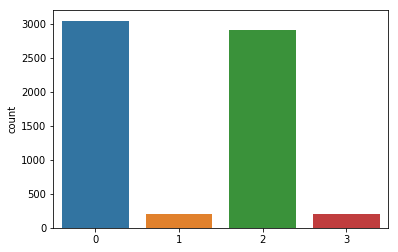

In [14]:
sns.countplot(y_data)

<b>We can see that classes are not balanced. </b> We will perform UnderSampling in Model 2 to handle class imbalance

Defining various dictionaries to store the result of evaluation

In [15]:
model_test_accuracy_comparisons = dict()
model_test_precision_comparisons = dict()
model_test_recall_comparisons = dict()
model_test_f1_comparisons = dict()
model_train_time_comparisons = dict()

###  For this task, we have tried six different model architecture where we experimented with parameters like:
1) Handling Class imbalance problem - Model 1 <br/> 2) Changing the number of hidden layers - Model 3 <br/> 3) Adding padding - Model 4 <br/> 4) Adding drop out layer - Model 5 <br/> 5) Changing the kernel size - Model 5 <br/> 6) Changing the number of filters - Model 6 <br/>

## Model 1 
<a id="model1_architecture"></a>

### Model Architecture

We are creating a sequential model in which we are creating the model layer-by-layer. The architecture consists of convolutional layers, max pooling layers, dropout layers and fully connected layers. In Model 1, we have 3 convolutional layers. <br/> <br/>
1) <b>First convolutional layer</b> consists consists of <b>32 filters</b> each of <b>size 3 x 3</b>. We have also specified the input shape in the first layer, which is 1 x84 x 84. We are using <b>Rectified linear unit (ReLU)</b> activation function for <b>all the layers</b> except the final output layer. <br/>
2) The next layer is a <b>pooling layer</b>. The pooling layers are used to reduce dimension. In our model we are using <b>Max Pooling</b> with a <b>2x2 window </b>. This will considers the maximum value in the 2x2 window. <br/>
3) <b>Second convolutional</b> layer consists consists of <b>32 filters</b> each of<b> size 3 x 3</b>. Followed by another max pooling layer of 2x2 window. <br/>
4) <b>Third convolutional layer </b>consists consists of <b>64 filters </b>each of size 3 x 3. Followed by another max pooling layer of 2x2 window. Usually, the number of filters in the convolutional layer grows after each layer. The first layers with lower number of filter learns simple features of the images whereas the deeper layers learn more complex features. <br/>
5) After that we have added a <b>flatten layer</b> that flattened the 3D feature map output from the convolutional layer to 1D feature vectors before adding in the fully connected layers.<br/>
6) Next layer is the <b>dense layer</b> (fully connected layer) that has <b>256 neurons</b>. This is followed by <b>dropout layer</b> with a dropout rate of 0.5. A dropout layer with dropout rate of 0.5 means 50% of the neurons will be turned off randomly. This helps prevent overfitting by making all the neurons learn something about the data and not rely on just a few neurons. Thus generalizing better and prevent overfitting. <br/>
7) The final output layer is another <b>dense layer</b> which has number of neurons equal to the number of classes. Since it is a multi-class classification problem, the activation function is set to <b>softmax</b>

<b> <font color="red">In Model 1 we are not handling class imbalance problem </font></b>

Split data into training and test partitions

In [16]:
# Perfrom split to train, validation, test
X_train, X_test, y_train, y_test = \
train_test_split(X_data, y_data, random_state=0, test_size = 0.30, train_size = 0.7)

In [17]:
X_train.shape

(4456, 1, 84, 84)

In [18]:
y_train.shape

(4456,)

Reshape output data for use with a neural network.

In [19]:
# Count the number of clases
num_classes = len(set(y_data))
# Convert class vectors to binary class matrices.
y_train_encoder = sklearn.preprocessing.LabelEncoder()
y_train_num = y_train_encoder.fit_transform(y_train)
y_train_wide = keras.utils.to_categorical(y_train_num, num_classes)

y_test_num = y_train_encoder.fit_transform(y_test)
y_test_wide = keras.utils.to_categorical(y_test_num, num_classes)

Record the number to label mapping

In [20]:
classes_num_label = dict()

for idx, lbl in enumerate(y_train_encoder.classes_):
    classes_num_label[idx] = lbl

Print a few randomly sampled example images.

(4456, 1, 84, 84)


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  if sys.path[0] == '':


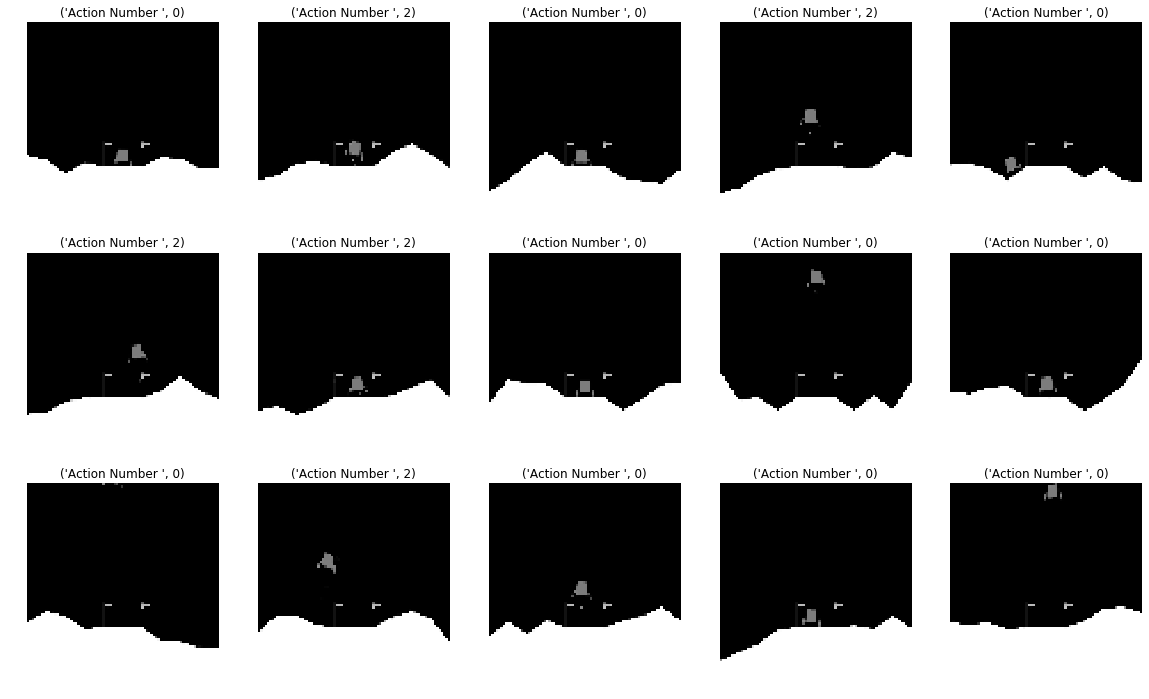

In [21]:
pltsize=4
row_images = 3
col_images = 5
plt.figure(figsize=(col_images*pltsize, row_images*pltsize))

print(X_train.shape)

for i in range(row_images * col_images):
    i_rand = random.randint(0, X_train.shape[0])
    plt.subplot(row_images,col_images,i+1)
    plt.axis('off')
    plt.imshow(sp.misc.toimage(X_train[i_rand][0]),cmap='gray')
    plt.title(("Action Number ",y_train[i_rand]))
    

## Modelling

The model is compiled with binary cross entropy loss function and the Adam optimizer is used. The ‘accuracy’ metric is used to evaluate the model. Adam is an optimization algorithm that updates the network weights in an iterative manner. <b>For Adam Optimizer, we have taken the default value for learning rate (lr=0.001).</b>

In [22]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 82, 82)        320       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 82, 82)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 41, 41)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 39, 39)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 32, 39, 39)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 19, 19)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 17, 17)        18496     
__________

Train the model. We allow the model to overfit but save the best set of weights based on validation loss as we go. Then at the end of training (assuming the model has overfit) we revert back to the saved model.

In [23]:
batch_size = 128
epochs = 50

# Set up the callback to save the best model based on validaion data
best_weights_filepath = './best_weights_notebook_model1.hdf5'
mcp = ModelCheckpoint(best_weights_filepath, monitor="val_acc",
                      save_best_only=True, save_weights_only=False)

start = time.time()
history = model.fit(X_train, y_train_wide,
          batch_size=batch_size,
          epochs=epochs,
          verbose = 1,
          validation_split = 0.2,
          shuffle=True,
          callbacks=[mcp])
end = time.time()
timetaken=end - start
model_train_time_comparisons['Model 1'] = timetaken
#reload best weights
model.load_weights(best_weights_filepath)

Train on 3564 samples, validate on 892 samples
Epoch 1/50
3564/3564 [==============================] - 43s 12ms/step - loss: 0.4056 - acc: 0.7947 - val_loss: 0.3448 - val_acc: 0.8523
Epoch 2/50
3564/3564 [==============================] - 48s 13ms/step - loss: 0.3488 - acc: 0.8496 - val_loss: 0.3251 - val_acc: 0.8590
Epoch 3/50
3564/3564 [==============================] - 47s 13ms/step - loss: 0.3240 - acc: 0.8610 - val_loss: 0.3153 - val_acc: 0.8697
Epoch 4/50
3564/3564 [==============================] - 47s 13ms/step - loss: 0.3129 - acc: 0.8672 - val_loss: 0.3002 - val_acc: 0.8711
Epoch 5/50
3564/3564 [==============================] - 47s 13ms/step - loss: 0.3045 - acc: 0.8664 - val_loss: 0.2988 - val_acc: 0.8688
Epoch 6/50
3564/3564 [==============================] - 47s 13ms/step - loss: 0.2960 - acc: 0.8697 - val_loss: 0.2976 - val_acc: 0.8694
Epoch 7/50
3564/3564 [==============================] - 48s 14ms/step - loss: 0.2947 - acc: 0.8683 - val_loss: 0.2976 - val_acc: 0.8711
E

Plot some evaluation stats

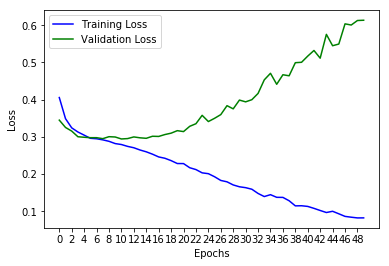

In [24]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,epochs)[0::2])
plt.legend()
plt.show()

## Evaluation

We have loaded the best model saved by ModelCheckpoint and use the predict function to predict the classes of the images in the array X_test.

In [25]:
y_pred = model.predict_classes(X_test)
# Print performance details
accuracy = metrics.accuracy_score(y_test_num, y_pred) # , normalize=True, sample_weight=None
model_test_accuracy_comparisons["Model 1"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test_num, y_pred))
report = metrics.classification_report(y_test_num, y_pred)
model_test_precision_comparisons["Model 1"] = report.split('\n')[-2].split('      ')[1]
model_test_recall_comparisons["Model 1"] = report.split('\n')[-2].split('      ')[2]
model_test_f1_comparisons["Model 1"] = report.split('\n')[-2].split('      ')[3]
print("Confusion Matrix")
pd.crosstab(np.array(y_test_num), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.73992673992674
              precision    recall  f1-score   support

           0       0.83      0.65      0.73       894
           1       0.40      0.07      0.11        60
           2       0.69      0.92      0.79       896
           3       0.00      0.00      0.00        61

   micro avg       0.74      0.74      0.74      1911
   macro avg       0.48      0.41      0.41      1911
weighted avg       0.73      0.74      0.72      1911

Confusion Matrix


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/p

Predicted,0,1,2,All
True,,,,
0,585,4,305,894
1,25,4,31,60
2,69,2,825,896
3,23,0,38,61
All,702,10,1199,1911


We are getting 73.5% Accuracy by this model. But their is class imbalance problem in the dataset, so we need to fix that problem. We can see from the confusion matrix, our model is not able to predict class 1 and class 3. Instead of them, it is simply predicting the majority class which is class 0 and class 2. 

<b>Persist A Model </b>

In [26]:
filepath = "model1_part1.mod"
model.save(filepath)

## Model 2 

### Model Architecture



In this we have used the same Architecture as [Model 1 Architecture](#model1_architecture). But we have <b>handled the class imbalance</b> problem by using <b>undersampling of data </b>with the help of imblearn.RandomUnderSampler. In Undersampling we removing some observations of the majority class so as to balance the class distribution.

In [27]:
# Perfrom split to train and test
X_train, X_test, y_train, y_test = \
train_test_split(X_data, y_data, random_state=0, test_size = 0.30, train_size = 0.7)

In [28]:
X_train.shape

(4456, 1, 84, 84)

In [29]:
X_test.shape

(1911, 1, 84, 84)

Reshape output data for use with a neural network.

In [30]:
# Count the number of clases
num_classes = len(set(y_data))
# Convert class vectors to binary class matrices.
y_train_encoder = sklearn.preprocessing.LabelEncoder()
y_train_num = y_train_encoder.fit_transform(y_train)
y_train_wide = keras.utils.to_categorical(y_train_num, num_classes)

y_test_num = y_train_encoder.fit_transform(y_test)
y_test_wide = keras.utils.to_categorical(y_test_num, num_classes)

Distribution of labels

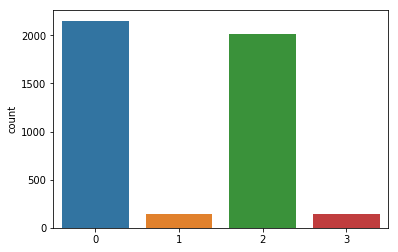

In [31]:
sns.countplot(y_train)

In [32]:
print(X_train.shape)

(4456, 1, 84, 84)


<b>Apply under sampling to balance the training dataset</b>

Undersampling in data analysis is a technique used to adjust the class distribution of a data set that is the ratio between the different classes in the dataset.

(576, 7056)
(576,)


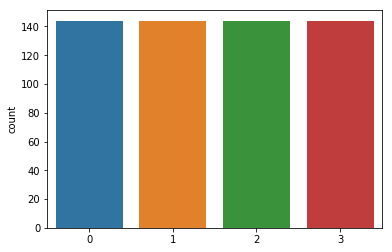

In [33]:
rus = RandomUnderSampler(return_indices=True)
#We also need to reshape X_train and X_test to use the Random Under Sampler
X_train_rus, y_train_rus, idx_resampled =rus.fit_sample(X_train.reshape(len(X_train), ROWS*COLS*CHANNELS), y_train)

print(X_train_rus.shape)
print(y_train_rus.shape)

X_train_rus, y_train_rus = shuffle(X_train_rus, y_train_rus)

X_train_rus = X_train_rus.reshape(len(X_train_rus), CHANNELS,ROWS, COLS)

# Plot a bar plot of the labels
sns.countplot(y_train_rus) 
#class distribution is adjusted

# convert to binary encoded labels
y_train_rus_wide = keras.utils.to_categorical(y_train_rus, num_classes)

Show some screens

(576, 1, 84, 84)


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  if sys.path[0] == '':


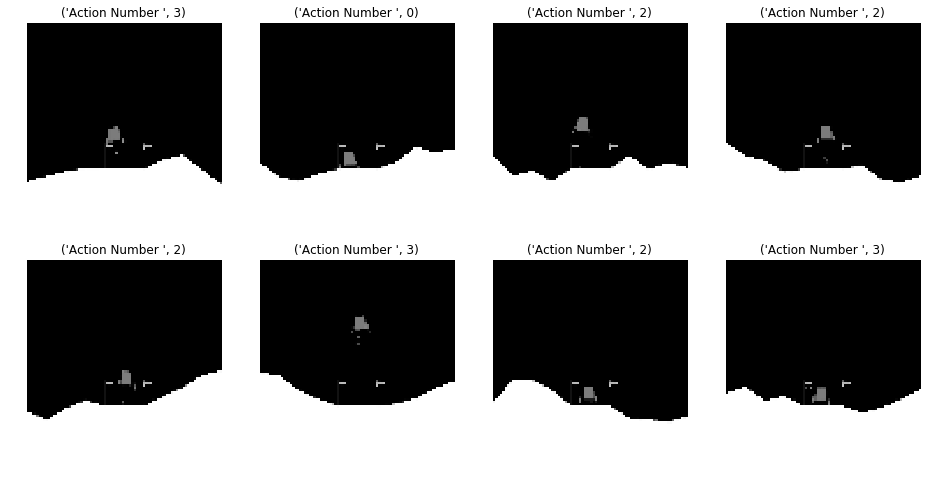

In [34]:
pltsize=4
row_images = 2
col_images = 4
plt.figure(figsize=(col_images*pltsize, row_images*pltsize))

print(X_train_rus.shape)

for i in range(row_images * col_images):
    i_rand = random.randint(0, X_train_rus.shape[0])
    plt.subplot(row_images,col_images,i+1)
    plt.axis('off')
    plt.imshow(sp.misc.toimage(X_train_rus[i_rand][0]),cmap='gray')
    plt.title(("Action Number ",y_train_rus[i_rand]))
    

<b>Modelling </b>

The model is compiled with binary cross entropy loss function and the Adam optimizer is used. The ‘accuracy’ metric is used to evaluate the model. Adam is an optimization algorithm that updates the network weights in an iterative manner. <b>For Adam Optimizer, we have taken the default value for learning rate (lr=0.001).</b>

In [35]:
model2 = Sequential()
model2.add(Conv2D(32, (3, 3), input_shape=input_shape))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(32, (3, 3)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(64, (3, 3)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Flatten())
model2.add(Dense(256))
model2.add(Activation('relu'))
model2.add(Dropout(0.5))
model2.add(Dense(num_classes))
model2.add(Activation('softmax'))

model2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 82, 82)        320       
_________________________________________________________________
activation_6 (Activation)    (None, 32, 82, 82)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 41, 41)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 39, 39)        9248      
_________________________________________________________________
activation_7 (Activation)    (None, 32, 39, 39)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 19, 19)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 64, 17, 17)        18496     
__________

Train the model. We allow the model to overfit but save the best set of weights based on validation loss as we go. Then at the end of training (assuming the model has overfit) we revert back to the saved model.

In [36]:
batch_size = 128
epochs = 50

# Set up the callback to save the best model based on validaion data
best_weights_filepath = './best_weights_notebook_model2.hdf5'
mcp = ModelCheckpoint(best_weights_filepath, monitor="val_acc",
                      save_best_only=True, save_weights_only=False)

start = time.time()
history = model2.fit(X_train_rus, y_train_rus_wide,
          batch_size=batch_size,
          epochs=epochs,
          verbose = 1,
          validation_split = 0.2,
          shuffle=True,
          callbacks=[mcp])

end = time.time()
timetaken=end - start
model_train_time_comparisons['Model 2'] = timetaken

#reload best weights
model2.load_weights(best_weights_filepath)

Train on 460 samples, validate on 116 samples
Epoch 1/50
460/460 [==============================] - 6s 14ms/step - loss: 0.5624 - acc: 0.7500 - val_loss: 0.5627 - val_acc: 0.7500
Epoch 2/50
460/460 [==============================] - 6s 14ms/step - loss: 0.5529 - acc: 0.7500 - val_loss: 0.5529 - val_acc: 0.7500
Epoch 3/50
460/460 [==============================] - 6s 13ms/step - loss: 0.5429 - acc: 0.7500 - val_loss: 0.5336 - val_acc: 0.7565
Epoch 4/50
460/460 [==============================] - 6s 14ms/step - loss: 0.5204 - acc: 0.7560 - val_loss: 0.5190 - val_acc: 0.7716
Epoch 5/50
460/460 [==============================] - 6s 13ms/step - loss: 0.5059 - acc: 0.7554 - val_loss: 0.5203 - val_acc: 0.7694
Epoch 6/50
460/460 [==============================] - 6s 13ms/step - loss: 0.4829 - acc: 0.7745 - val_loss: 0.5047 - val_acc: 0.7716
Epoch 7/50
460/460 [==============================] - 6s 13ms/step - loss: 0.4696 - acc: 0.7685 - val_loss: 0.4938 - val_acc: 0.7672
Epoch 8/50
460/460 [===

Plot some evaluation stats

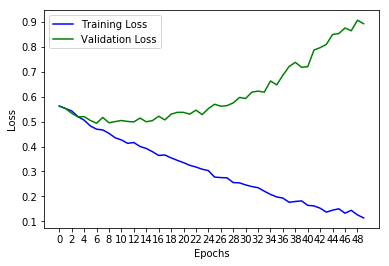

In [37]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,epochs)[0::2])
plt.legend()
plt.show()

### Evaluation

We have loaded the best model saved by ModelCheckpoint and use the predict function to predict the classes of the images in the array X_test.

In [38]:
y_pred = model2.predict_classes(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test_num, y_pred) # , normalize=True, sample_weight=None
model_test_accuracy_comparisons["Model 2"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test_num, y_pred))
report = metrics.classification_report(y_test_num, y_pred)
model_test_precision_comparisons["Model 2"] = report.split('\n')[-2].split('      ')[1]
model_test_recall_comparisons["Model 2"] = report.split('\n')[-2].split('      ')[2]
model_test_f1_comparisons["Model 2"] = report.split('\n')[-2].split('      ')[3]
print("Confusion Matrix")
pd.crosstab(np.array(y_test_num), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.5013082155939299
              precision    recall  f1-score   support

           0       0.74      0.57      0.65       894
           1       0.11      0.57      0.18        60
           2       0.67      0.42      0.52       896
           3       0.09      0.52      0.16        61

   micro avg       0.50      0.50      0.50      1911
   macro avg       0.40      0.52      0.38      1911
weighted avg       0.67      0.50      0.56      1911

Confusion Matrix


Predicted,0,1,2,3,All
True,,,,,
0,512,120,158,104,894
1,8,34,13,5,60
2,161,149,380,206,896
3,7,8,14,32,61
All,688,311,565,347,1911


Now we are getting 44.7% Accuracy by handling the class imbalance problem.

<b>Persist A Model</b>

In [39]:
filepath = "model2_part1.mod"
model2.save(filepath)

## Model 3

<a id="model3_architecture"></a>

### Model Architecture

In Model 3, we have added another convolutional layer to [Model 1 Architecture](#model1_architecture) <br/> <br/>
1) <b>First convolutional layer</b> consists consists of <b>32 filters</b> each of <b>size 3 x 3</b>. We are using <b>Rectified linear unit (ReLU)</b> activation function for <b>all the layers</b> except the final output layer. Followed by max pooling layer of 2x2 window. <br/>
2) <b>Second convolutional</b> layer consists consists of <b>32 filters</b> each of<b> size 3 x 3</b>. Followed by another max pooling layer of 2x2 window. <br/>
3) <b>Third convolutional</b> layer consists consists of <b>32 filters</b> each of<b> size 3 x 3</b>. Followed by another max pooling layer of 2x2 window. <br/>
4) <b>Fourth convolutional layer </b>consists consists of <b>64 filters </b>each of size 3 x 3. Followed by another max pooling layer of 2x2 window. <br/>
5) Next layer is the <b>dense layer</b> (fully connected layer) that has <b>256 neurons</b>. This is followed by <b>dropout layer</b> with a dropout rate of 0.5.<br/>
6) The final output layer is another <b>dense layer</b> which has number of neurons equal to the number of classes. Since it is a multi-class classification problem, the activation function is set to <b>softmax</b>

<b> <font color="red">In Model 3 we are handling class imbalance problem </font></b>

In [40]:
# Perfrom split to train and test
X_train, X_test, y_train, y_test = \
train_test_split(X_data, y_data, random_state=0, test_size = 0.30, train_size = 0.7)

In [41]:
X_train.shape

(4456, 1, 84, 84)

In [42]:
X_test.shape

(1911, 1, 84, 84)

In [43]:
# Count the number of clases
num_classes = len(set(y_data))
# Convert class vectors to binary class matrices.
y_train_encoder = sklearn.preprocessing.LabelEncoder()
y_train_num = y_train_encoder.fit_transform(y_train)
y_train_wide = keras.utils.to_categorical(y_train_num, num_classes)

y_test_num = y_train_encoder.fit_transform(y_test)
y_test_wide = keras.utils.to_categorical(y_test_num, num_classes)

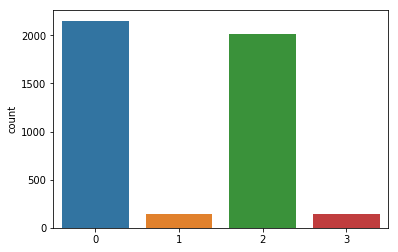

In [44]:
sns.countplot(y_train)

<b>Apply under sampling to balance the training dataset</b>

Undersampling in data analysis is a technique used to adjust the class distribution of a data set that is the ratio between the different classes in the dataset.

(576, 7056)
(576,)


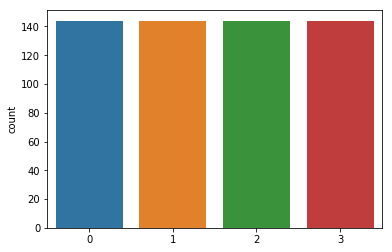

In [45]:
rus = RandomUnderSampler(return_indices=True)
X_train_rus, y_train_rus, idx_resampled =rus.fit_sample(X_train.reshape(len(X_train), ROWS*COLS*CHANNELS), y_train)

print(X_train_rus.shape)
print(y_train_rus.shape)

X_train_rus, y_train_rus = shuffle(X_train_rus, y_train_rus)

X_train_rus = X_train_rus.reshape(len(X_train_rus), CHANNELS,ROWS, COLS)
#print(X_train_rus.shape) #(2144, 1, 64, 64)

# Plot a bar plot of the labels
#seaborn.countplot - Show value counts for a single categorical variable:
sns.countplot(y_train_rus) #class distribution is adjusted

# convert to binary encoded labels
y_train_rus_wide = keras.utils.to_categorical(y_train_rus, num_classes)

Show some screens

(576, 1, 84, 84)


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  if sys.path[0] == '':


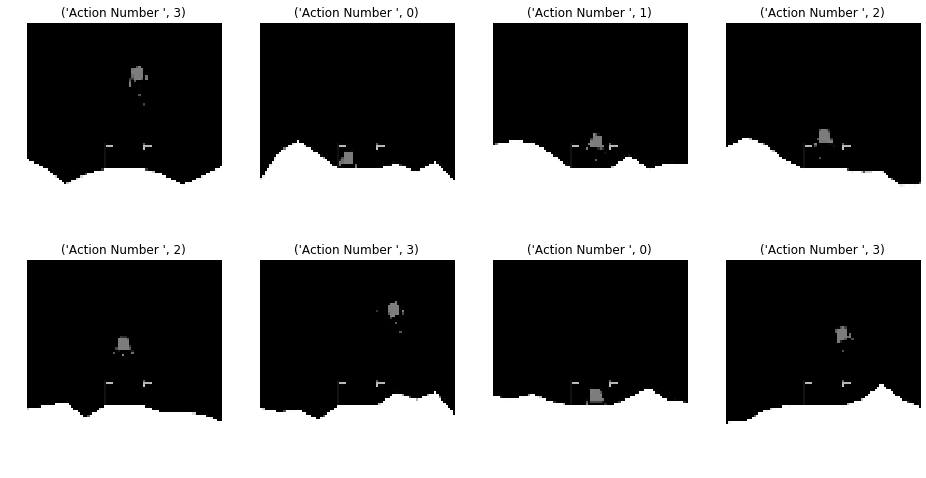

In [46]:
pltsize=4
row_images = 2
col_images = 4
plt.figure(figsize=(col_images*pltsize, row_images*pltsize))

print(X_train_rus.shape)

for i in range(row_images * col_images):
    i_rand = random.randint(0, X_train_rus.shape[0])
    plt.subplot(row_images,col_images,i+1)
    plt.axis('off')
    plt.imshow(sp.misc.toimage(X_train_rus[i_rand][0]),cmap='gray')
    plt.title(("Action Number ",y_train_rus[i_rand]))

<b>Modelling </b>

The model is compiled with binary cross entropy loss function and the Adam optimizer is used. The ‘accuracy’ metric is used to evaluate the model. Adam is an optimization algorithm that updates the network weights in an iterative manner. <b>For Adam Optimizer, we have taken the default value for learning rate (lr=0.001).</b>


In [47]:
model3 = Sequential()
model3.add(Conv2D(32, (3, 3), input_shape=input_shape))
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Conv2D(32, (3, 3)))
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Conv2D(32, (3, 3)))
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Conv2D(64, (3, 3)))
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Flatten())
model3.add(Dense(256))
model3.add(Activation('relu'))
model3.add(Dropout(0.5))
model3.add(Dense(num_classes))
model3.add(Activation('softmax'))

model3.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 32, 82, 82)        320       
_________________________________________________________________
activation_11 (Activation)   (None, 32, 82, 82)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 32, 41, 41)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 39, 39)        9248      
_________________________________________________________________
activation_12 (Activation)   (None, 32, 39, 39)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 32, 19, 19)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 17, 17)        9248      
__________

Train the model. We allow the model to overfit but save the best set of weights based on validation loss as we go. Then at the end of training (assuming the model has overfit) we revert back to the saved model.

In [48]:
batch_size = 128
epochs = 50

# Set up the callback to save the best model based on validaion data
best_weights_filepath = './best_weights_notebook_model3.hdf5'
mcp = ModelCheckpoint(best_weights_filepath, monitor="val_acc",
                      save_best_only=True, save_weights_only=False)

start = time.time()
history = model3.fit(X_train_rus, y_train_rus_wide,
          batch_size=batch_size,
          epochs=epochs,
          verbose = 1,
          validation_split = 0.2,
          shuffle=True,
          callbacks=[mcp])

end = time.time()
timetaken=end - start
model_train_time_comparisons['Model 3'] = timetaken

#reload best weights
model3.load_weights(best_weights_filepath)

Train on 460 samples, validate on 116 samples
Epoch 1/50
460/460 [==============================] - 6s 14ms/step - loss: 0.5620 - acc: 0.7500 - val_loss: 0.5613 - val_acc: 0.7500
Epoch 2/50
460/460 [==============================] - 6s 13ms/step - loss: 0.5572 - acc: 0.7500 - val_loss: 0.5555 - val_acc: 0.7500
Epoch 3/50
460/460 [==============================] - 6s 13ms/step - loss: 0.5488 - acc: 0.7500 - val_loss: 0.5437 - val_acc: 0.7500
Epoch 4/50
460/460 [==============================] - 6s 14ms/step - loss: 0.5287 - acc: 0.7511 - val_loss: 0.5167 - val_acc: 0.7629
Epoch 5/50
460/460 [==============================] - 6s 14ms/step - loss: 0.5061 - acc: 0.7663 - val_loss: 0.5142 - val_acc: 0.7672
Epoch 6/50
460/460 [==============================] - 6s 14ms/step - loss: 0.4982 - acc: 0.7647 - val_loss: 0.5276 - val_acc: 0.7543
Epoch 7/50
460/460 [==============================] - 6s 14ms/step - loss: 0.4891 - acc: 0.7658 - val_loss: 0.5152 - val_acc: 0.7608
Epoch 8/50
460/460 [===

Plot some evaluation stats

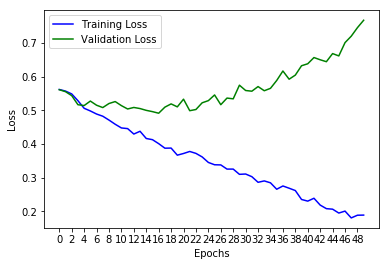

In [49]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,epochs)[0::2])
plt.legend()
plt.show()

### Evaluation
We have loaded the best model saved by ModelCheckpoint and use the predict function to predict the classes of the images in the array X_test.

In [50]:
y_pred = model3.predict_classes(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test_num, y_pred) # , normalize=True, sample_weight=None
model_test_accuracy_comparisons["Model 3"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test_num, y_pred))
report = metrics.classification_report(y_test_num, y_pred)
model_test_precision_comparisons["Model 3"] = report.split('\n')[-2].split('      ')[1]
model_test_recall_comparisons["Model 3"] = report.split('\n')[-2].split('      ')[2]
model_test_f1_comparisons["Model 3"] = report.split('\n')[-2].split('      ')[3]
print("Confusion Matrix")
pd.crosstab(np.array(y_test_num), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.5170068027210885
              precision    recall  f1-score   support

           0       0.73      0.54      0.62       894
           1       0.10      0.50      0.17        60
           2       0.70      0.50      0.58       896
           3       0.08      0.41      0.13        61

   micro avg       0.52      0.52      0.52      1911
   macro avg       0.40      0.49      0.38      1911
weighted avg       0.68      0.52      0.57      1911

Confusion Matrix


Predicted,0,1,2,3,All
True,,,,,
0,485,158,167,84,894
1,9,30,15,6,60
2,159,84,448,205,896
3,9,16,11,25,61
All,662,288,641,320,1911


By adding another convolutional layer, we were able to increase the increase to 52.17%

<b>Persist A Model</b>

In [51]:
filepath = "model3_part1.mod"
model3.save(filepath)

## Model 4

### Model Architecture

In Model 4, we have introduced padding to [Model3 Architecture](#model3_architecture) <br/>

1) <b>First convolutional layer</b> consists consists of <b>32 filters</b> each of <b>size 3 x 3.</b> We have set padding to same. It is followed by max pooling layer of 2x2 window. <br/>
2) <b>Second convolutional</b> layer consists consists of <b>32 filters</b> each of<b> size 3 x 3.</b> We have set padding to same. It is followed by another max pooling layer of 2x2 window. <br/>
3) <b>Third convolutional</b> layer consists consists of <b>32 filters</b> each of<b> size 3 x 3.</b> We have set padding to same. It is followed by another max pooling layer of 2x2 window. <br/>
4) <b>Fourth convolutional layer </b>consists consists of <b>64 filters </b>each of size 3 x 3. We have set padding to same. It is followed by another max pooling layer of 2x2 window. <br/>
5) Next layer is the <b>dense layer</b> (fully connected layer) that has <b>256 neurons</b>. This is followed by <b>dropout layer</b> with a dropout rate of 0.5.<br/>
6) The final output layer is another <b>dense layer</b> which has number of neurons equal to the number of classes. Since it is a multi-class classification problem, the activation function is set to <b>softmax</b>

In convolution networks, we can either decrease the image size as we go from one network layer to another, or keep the size of the image same. Without padding the image size will get reduced for the next layer. Whereas with the introduction of adequate padding the size of the image remains same. In this way, we won't loss information on the corner of the image. 

<b> <font color="red">In Model 4 we are handling class imbalance problem </font></b>

In [52]:
# Perfrom split to train, validation, test
X_train, X_test, y_train, y_test = \
train_test_split(X_data, y_data, random_state=0, test_size = 0.30, train_size = 0.7)

In [53]:
# Count the number of clases
num_classes = len(set(y_data))
# Convert class vectors to binary class matrices.
y_train_encoder = sklearn.preprocessing.LabelEncoder()
y_train_num = y_train_encoder.fit_transform(y_train)
y_train_wide = keras.utils.to_categorical(y_train_num, num_classes)

y_test_num = y_train_encoder.fit_transform(y_test)
y_test_wide = keras.utils.to_categorical(y_test_num, num_classes)

<b>Apply under sampling to balance the training dataset</b>

Undersampling in data analysis is a technique used to adjust the class distribution of a data set that is the ratio between the different classes in the dataset.

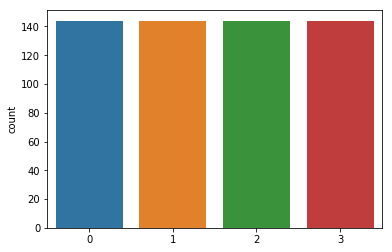

In [54]:
rus = RandomUnderSampler(return_indices=True)
X_train_rus, y_train_rus, idx_resampled =rus.fit_sample(X_train.reshape(len(X_train), ROWS*COLS*CHANNELS), y_train)

X_train_rus, y_train_rus = shuffle(X_train_rus, y_train_rus)
X_train_rus = X_train_rus.reshape(len(X_train_rus), CHANNELS,ROWS, COLS)

# Plot a bar plot of the labels
#seaborn.countplot - Show value counts for a single categorical variable:
sns.countplot(y_train_rus) #class distribution is adjusted

# convert to binary encoded labels
y_train_rus_wide = keras.utils.to_categorical(y_train_rus, num_classes)

Show some screens

(576, 1, 84, 84)


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  if sys.path[0] == '':


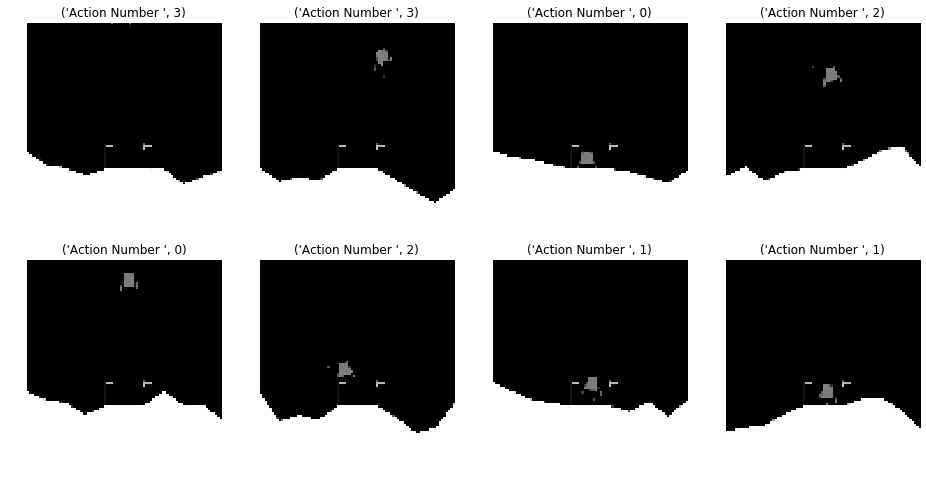

In [55]:
pltsize=4
row_images = 2
col_images = 4
plt.figure(figsize=(col_images*pltsize, row_images*pltsize))

print(X_train_rus.shape)

for i in range(row_images * col_images):
    i_rand = random.randint(0, X_train_rus.shape[0])
    plt.subplot(row_images,col_images,i+1)
    plt.axis('off')
    plt.imshow(sp.misc.toimage(X_train_rus[i_rand][0]),cmap='gray')
    plt.title(("Action Number ",y_train_rus[i_rand]))

<b>Modelling </b>

The model is compiled with binary cross entropy loss function and the Adam optimizer is used. The ‘accuracy’ metric is used to evaluate the model. Adam is an optimization algorithm that updates the network weights in an iterative manner. <b>For Adam Optimizer, we have taken the default value for learning rate (lr=0.001).</b>

In [56]:
#Introduced Padding
model4 = Sequential()
model4.add(Conv2D(32, (3, 3),padding='same', input_shape=input_shape))
model4.add(Activation('relu'))
model4.add(MaxPooling2D(pool_size=(2, 2)))

model4.add(Conv2D(32, (3, 3),padding='same'))
model4.add(Activation('relu'))
model4.add(MaxPooling2D(pool_size=(2, 2)))

model4.add(Conv2D(32, (3, 3),padding='same'))
model4.add(Activation('relu'))
model4.add(MaxPooling2D(pool_size=(2, 2)))

model4.add(Conv2D(64, (3, 3),padding='same'))
model4.add(Activation('relu'))
model4.add(MaxPooling2D(pool_size=(2, 2)))

model4.add(Flatten())
model4.add(Dense(256))
model4.add(Activation('relu'))
model4.add(Dropout(0.5))

model4.add(Dense(num_classes))
model4.add(Activation('softmax'))

model4.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 32, 84, 84)        320       
_________________________________________________________________
activation_17 (Activation)   (None, 32, 84, 84)        0         
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 32, 42, 42)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 32, 42, 42)        9248      
_________________________________________________________________
activation_18 (Activation)   (None, 32, 42, 42)        0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 32, 21, 21)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 21, 21)        9248      
__________

Train the model. We allow the model to overfit but save the best set of weights based on validation loss as we go. Then at the end of training (assuming the model has overfit) we revert back to the saved model.

In [57]:
batch_size = 128
epochs = 50

# Set up the callback to save the best model based on validaion data
best_weights_filepath = './best_weights_notebook_model4.hdf5'
mcp = ModelCheckpoint(best_weights_filepath, monitor="val_acc",
                      save_best_only=True, save_weights_only=False)
start = time.time()
history = model4.fit(X_train_rus, y_train_rus_wide,
          batch_size=batch_size,
          epochs=epochs,
          verbose = 1,
          validation_split = 0.2,
          shuffle=True,
          callbacks=[mcp])
end = time.time()
timetaken=end - start
model_train_time_comparisons['Model 4'] = timetaken

#reload best weights
model4.load_weights(best_weights_filepath)

Train on 460 samples, validate on 116 samples
Epoch 1/50
460/460 [==============================] - 7s 16ms/step - loss: 0.5644 - acc: 0.7500 - val_loss: 0.5616 - val_acc: 0.7500
Epoch 2/50
460/460 [==============================] - 7s 15ms/step - loss: 0.5589 - acc: 0.7500 - val_loss: 0.5583 - val_acc: 0.7500
Epoch 3/50
460/460 [==============================] - 7s 14ms/step - loss: 0.5536 - acc: 0.7500 - val_loss: 0.5501 - val_acc: 0.7500
Epoch 4/50
460/460 [==============================] - 7s 14ms/step - loss: 0.5421 - acc: 0.7500 - val_loss: 0.5296 - val_acc: 0.7500
Epoch 5/50
460/460 [==============================] - 7s 15ms/step - loss: 0.5312 - acc: 0.7467 - val_loss: 0.5147 - val_acc: 0.7522
Epoch 6/50
460/460 [==============================] - 6s 14ms/step - loss: 0.5102 - acc: 0.7511 - val_loss: 0.5108 - val_acc: 0.7500
Epoch 7/50
460/460 [==============================] - 7s 15ms/step - loss: 0.4998 - acc: 0.7543 - val_loss: 0.5143 - val_acc: 0.7478
Epoch 8/50
460/460 [===

Plot some evaluation stats

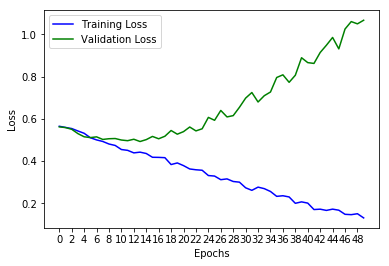

In [58]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,epochs)[0::2])
plt.legend()
plt.show()

### Evaluation
We have loaded the best model saved by ModelCheckpoint and use the predict function to predict the classes of the images in the array X_test.

In [59]:
y_pred = model4.predict_classes(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test_num, y_pred) # , normalize=True, sample_weight=None
model_test_accuracy_comparisons["Model 4"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test_num, y_pred))
report = metrics.classification_report(y_test_num, y_pred)
model_test_precision_comparisons["Model 4"] = report.split('\n')[-2].split('      ')[1]
model_test_recall_comparisons["Model 4"] = report.split('\n')[-2].split('      ')[2]
model_test_f1_comparisons["Model 4"] = report.split('\n')[-2].split('      ')[3]
print("Confusion Matrix")
pd.crosstab(np.array(y_test_num), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.5463108320251178
              precision    recall  f1-score   support

           0       0.67      0.64      0.66       894
           1       0.14      0.50      0.21        60
           2       0.69      0.47      0.56       896
           3       0.08      0.28      0.12        61

   micro avg       0.55      0.55      0.55      1911
   macro avg       0.39      0.47      0.39      1911
weighted avg       0.64      0.55      0.58      1911

Confusion Matrix


Predicted,0,1,2,3,All
True,,,,,
0,575,94,161,64,894
1,15,30,9,6,60
2,255,82,422,137,896
3,10,14,20,17,61
All,855,220,612,224,1911


We are getting 46.4% Accuracy when we have introduced padding to Model 3. 

<b>Persist A Model</b>

In [60]:
filepath = "model4_part1.mod"
model4.save(filepath)

## Model 5

### Model Architecture

Model 5 has four convolutional layers similar to [Model3 Architecture](#model3_architecture). In this Model, we have changed the size of the filter from 3 x 3 to 5 x 5. Also after the third layer, we have introduced a dropout layer to prevent overfitting of the model.

1) <b>First convolutional layer</b> consists consists of <b>32 filters</b> each of <b>size 5 x 5</b>. We are using <b>Rectified linear unit (ReLU)</b> activation function for <b>all the layers</b> except the final output layer. Followed by max pooling layer of 2x2 window. <br/>
2) <b>Second convolutional</b> layer consists consists of <b>32 filters</b> each of<b> size 5 x 5</b>. Followed by another max pooling layer of 2x2 window<br/>
3) <b>Third convolutional</b> layer consists consists of <b>32 filters</b> each of<b> size 5 x 5</b>. Followed by another max pooling layer of 2x2 window. This is followed by <b>dropout layer</b> with a dropout rate of 0.5.<br/>
4) <b>Fourth convolutional layer </b>consists consists of <b>64 filters </b>each of size 5 x 5. Followed by another max pooling layer of 2x2 window. <br/>
5) Next layer is the <b>dense layer</b> (fully connected layer) that has <b>256 neurons</b>. This is followed by <b>dropout layer</b> with a dropout rate of 0.5.<br/>
6) The final output layer is another <b>dense layer</b> which has number of neurons equal to the number of classes. Since it is a multi-class classification problem, the activation function is set to <b>softmax</b>

A dropout layer with dropout rate of 0.5 means 50% of the neurons will be turned off randomly. This helps to prevent overfitting by making all the neurons learn something about the data and not rely on just a few neurons. Thus generalizing better and prevent overfitting.

<b> <font color="red">In Model 5 we are handling class imbalance problem </font></b>

In [61]:
# Perfrom split to train, validation, test
X_train, X_test, y_train, y_test = \
train_test_split(X_data, y_data, random_state=0, test_size = 0.30, train_size = 0.7)

In [62]:
# Count the number of clases
num_classes = len(set(y_data))
# Convert class vectors to binary class matrices.
y_train_encoder = sklearn.preprocessing.LabelEncoder()
y_train_num = y_train_encoder.fit_transform(y_train)
y_train_wide = keras.utils.to_categorical(y_train_num, num_classes)

y_test_num = y_train_encoder.fit_transform(y_test)
y_test_wide = keras.utils.to_categorical(y_test_num, num_classes)

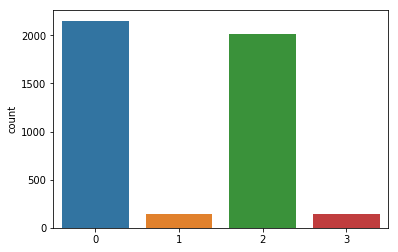

In [63]:
sns.countplot(y_train)

Apply under sampling to balance the training dataset

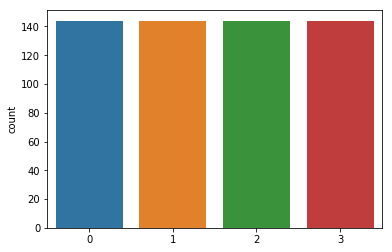

In [64]:
rus = RandomUnderSampler(return_indices=True)
X_train_rus, y_train_rus, idx_resampled =rus.fit_sample(X_train.reshape(len(X_train), ROWS*COLS*CHANNELS), y_train)

X_train_rus, y_train_rus = shuffle(X_train_rus, y_train_rus)

X_train_rus = X_train_rus.reshape(len(X_train_rus), CHANNELS,ROWS, COLS)

# Plot a bar plot of the labels
#seaborn.countplot - Show value counts for a single categorical variable:
sns.countplot(y_train_rus) #class distribution is adjusted

# convert to binary encoded labels
y_train_rus_wide = keras.utils.to_categorical(y_train_rus, num_classes)

Show some screens

(576, 1, 84, 84)


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  if sys.path[0] == '':


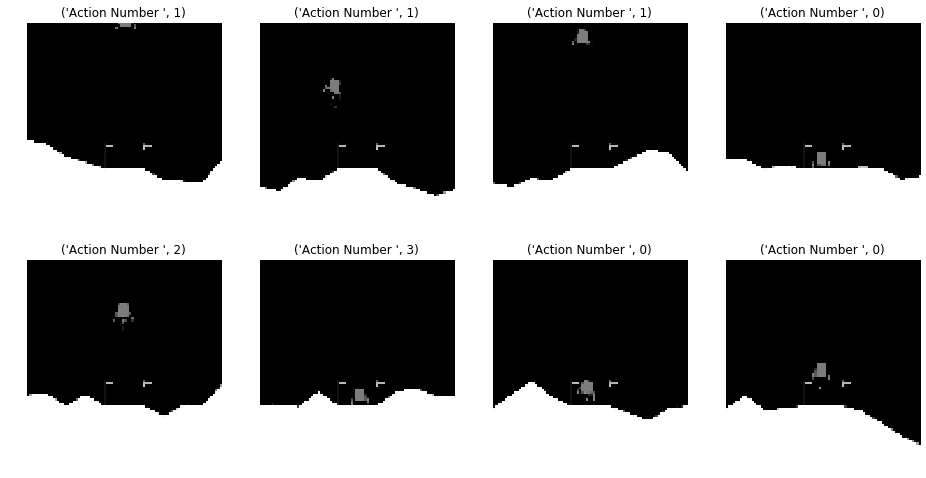

In [65]:
pltsize=4
row_images = 2
col_images = 4
plt.figure(figsize=(col_images*pltsize, row_images*pltsize))

print(X_train_rus.shape)

for i in range(row_images * col_images):
    i_rand = random.randint(0, X_train_rus.shape[0])
    plt.subplot(row_images,col_images,i+1)
    plt.axis('off')
    plt.imshow(sp.misc.toimage(X_train_rus[i_rand][0]),cmap='gray')
    plt.title(("Action Number ",y_train_rus[i_rand]))

<b>Modelling </b>

In [66]:
model5 = Sequential()
model5.add(Conv2D(32, (5, 5), input_shape=input_shape))
model5.add(Activation('relu'))
model5.add(MaxPooling2D(pool_size=(2, 2)))

model5.add(Conv2D(32, (5, 5)))
model5.add(Activation('relu'))
model5.add(MaxPooling2D(pool_size=(2, 2)))

model5.add(Conv2D(32, (5, 5)))
model5.add(Activation('relu'))
model5.add(MaxPooling2D(pool_size=(2, 2)))
model5.add(Dropout(0.25))

model5.add(Conv2D(64, (5, 5)))
model5.add(Activation('relu'))
model5.add(MaxPooling2D(pool_size=(2, 2)))

model5.add(Flatten())
model5.add(Dense(256))
model5.add(Activation('relu'))
model5.add(Dropout(0.5))
model5.add(Dense(num_classes))
model5.add(Activation('softmax'))

model5.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model5.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 32, 80, 80)        832       
_________________________________________________________________
activation_23 (Activation)   (None, 32, 80, 80)        0         
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 32, 40, 40)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 32, 36, 36)        25632     
_________________________________________________________________
activation_24 (Activation)   (None, 32, 36, 36)        0         
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 32, 18, 18)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 32, 14, 14)        25632     
__________

Train the model. We allow the model to overfit but save the best set of weights based on validation loss as we go. Then at the end of training (assuming the model has overfit) we revert back to the saved model.

In [67]:
batch_size = 128
epochs = 50

# Set up the callback to save the best model based on validaion data
best_weights_filepath = './best_weights_notebook_model5.hdf5'
mcp = ModelCheckpoint(best_weights_filepath, monitor="val_acc",
                      save_best_only=True, save_weights_only=False)

start = time.time()
history = model5.fit(X_train_rus, y_train_rus_wide,
          batch_size=batch_size,
          epochs=epochs,
          verbose = 1,
          validation_split = 0.2,
          shuffle=True,
          callbacks=[mcp])

end = time.time()
timetaken=end - start
model_train_time_comparisons['Model 5'] = timetaken
#reload best weights
model5.load_weights(best_weights_filepath)

Train on 460 samples, validate on 116 samples
Epoch 1/50
460/460 [==============================] - 7s 15ms/step - loss: 0.5633 - acc: 0.7500 - val_loss: 0.5619 - val_acc: 0.7500
Epoch 2/50
460/460 [==============================] - 7s 16ms/step - loss: 0.5614 - acc: 0.7500 - val_loss: 0.5604 - val_acc: 0.7500
Epoch 3/50
460/460 [==============================] - 7s 14ms/step - loss: 0.5588 - acc: 0.7500 - val_loss: 0.5538 - val_acc: 0.7500
Epoch 4/50
460/460 [==============================] - 7s 15ms/step - loss: 0.5488 - acc: 0.7500 - val_loss: 0.5364 - val_acc: 0.7500
Epoch 5/50
460/460 [==============================] - 7s 14ms/step - loss: 0.5323 - acc: 0.7560 - val_loss: 0.5121 - val_acc: 0.7565
Epoch 6/50
460/460 [==============================] - 7s 15ms/step - loss: 0.5238 - acc: 0.7582 - val_loss: 0.5077 - val_acc: 0.7586
Epoch 7/50
460/460 [==============================] - 7s 14ms/step - loss: 0.5096 - acc: 0.7609 - val_loss: 0.5024 - val_acc: 0.7716
Epoch 8/50
460/460 [===

Plot some evaluation stats

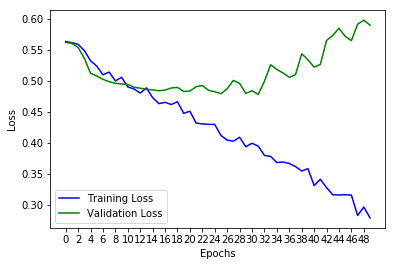

In [68]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,epochs)[0::2])
plt.legend()
plt.show()

<b>Evaluation</b>

In [69]:
y_pred = model5.predict_classes(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test_num, y_pred) # , normalize=True, sample_weight=None
model_test_accuracy_comparisons["Model 5"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test_num, y_pred))
report = metrics.classification_report(y_test_num, y_pred)
model_test_precision_comparisons["Model 5"] = report.split('\n')[-2].split('      ')[1]
model_test_recall_comparisons["Model 5"] = report.split('\n')[-2].split('      ')[2]
model_test_f1_comparisons["Model 5"] = report.split('\n')[-2].split('      ')[3]
print("Confusion Matrix")
pd.crosstab(np.array(y_test_num), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.5133437990580848
              precision    recall  f1-score   support

           0       0.75      0.55      0.63       894
           1       0.09      0.60      0.16        60
           2       0.67      0.49      0.57       896
           3       0.09      0.33      0.14        61

   micro avg       0.51      0.51      0.51      1911
   macro avg       0.40      0.49      0.37      1911
weighted avg       0.67      0.51      0.57      1911

Confusion Matrix


Predicted,0,1,2,3,All
True,,,,,
0,488,164,186,56,894
1,9,36,14,1,60
2,142,168,437,149,896
3,9,19,13,20,61
All,648,387,650,226,1911


<b>Persist A Model</b>

In [70]:
filepath = "model5_part1.mod"
model5.save(filepath)

## Model 6

### Model Architecture

In Model 6, we are <b>changing the number of filters</b>. Usually, the number of filters in the convolutional layer grows after each layer. The first few layers with lower number of filter learns simple features of the images whereas the deeper layers learn more complex features. So we have created a model in which we are increasing the number of filters as we go deeper <br/>
In Model 6, we have 4 convolutional layers. <br/> 
1) <b>First convolutional layer</b> consists consists of <b>32 filters</b> each of <b>size 3 x 3</b>. Followed by another max pooling layer of 2x2 window. <br/>
2) <b>Second convolutional</b> layer consists consists of <b>32 filters</b> each of<b> size 3 x 3</b>. Followed by another max pooling layer of 2x2 window. <br/>
3) <b>Third convolutional layer </b>consists consists of <b>64 filters </b>each of size 3 x 3. Followed by another max pooling layer of 2x2 window. <br/>
4) <b>Fourth convolutional layer </b>consists consists of <b>128 filters </b>each of size 3 x 3. Followed by another max pooling layer of 2x2 window. <br/>
5) Next layer is the <b>dense layer</b> (fully connected layer) that has <b>256 neurons</b>. This is followed by <b>dropout layer</b> with a dropout rate of 0.5.<br/>
6) The final output layer is another <b>dense layer</b> which has number of neurons equal to the number of classes. Since it is a multi-class classification problem, the activation function is set to <b>softmax</b>

<b> <font color="red">In Model 6 we are handling class imbalance problem </font></b>

In [71]:
# Perfrom split to train and test
X_train, X_test, y_train, y_test = \
train_test_split(X_data, y_data, random_state=0, test_size = 0.30, train_size = 0.7)

In [72]:
# Count the number of clases
num_classes = len(set(y_data))
# Convert class vectors to binary class matrices.
y_train_encoder = sklearn.preprocessing.LabelEncoder()
y_train_num = y_train_encoder.fit_transform(y_train)
y_train_wide = keras.utils.to_categorical(y_train_num, num_classes)

y_test_num = y_train_encoder.fit_transform(y_test)
y_test_wide = keras.utils.to_categorical(y_test_num, num_classes)

Apply under sampling to balance the training dataset

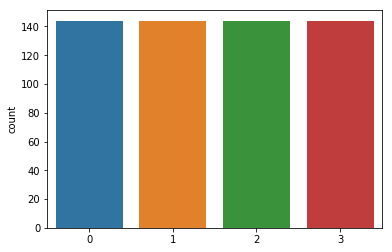

In [73]:
rus = RandomUnderSampler(return_indices=True)
X_train_rus, y_train_rus, idx_resampled =rus.fit_sample(X_train.reshape(len(X_train), ROWS*COLS*CHANNELS), y_train)


X_train_rus, y_train_rus = shuffle(X_train_rus, y_train_rus)

X_train_rus = X_train_rus.reshape(len(X_train_rus), CHANNELS,ROWS, COLS)
#print(X_train_rus.shape) #(2144, 1, 64, 64)

# Plot a bar plot of the labels
#seaborn.countplot - Show value counts for a single categorical variable:
sns.countplot(y_train_rus) #class distribution is adjusted

# convert to binary encoded labels
y_train_rus_wide = keras.utils.to_categorical(y_train_rus, num_classes)

Show some screens

(576, 1, 84, 84)


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  if sys.path[0] == '':


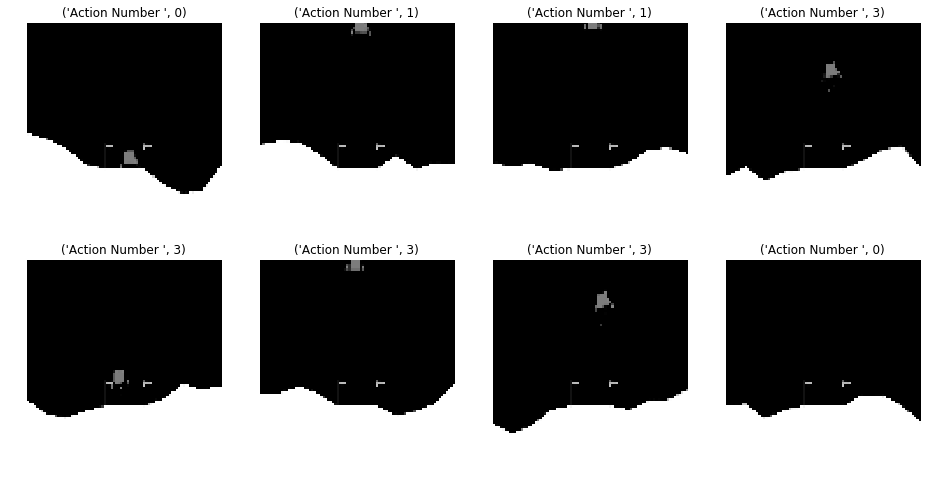

In [74]:
pltsize=4
row_images = 2
col_images = 4
plt.figure(figsize=(col_images*pltsize, row_images*pltsize))

print(X_train_rus.shape)

for i in range(row_images * col_images):
    i_rand = random.randint(0, X_train_rus.shape[0])
    plt.subplot(row_images,col_images,i+1)
    plt.axis('off')
    plt.imshow(sp.misc.toimage(X_train_rus[i_rand][0]),cmap='gray')
    plt.title(("Action Number ",y_train_rus[i_rand]))

<b>Modelling </b>

In [75]:
model6 = Sequential()
model6.add(Conv2D(32, (3, 3), input_shape=input_shape))
model6.add(Activation('relu'))
model6.add(MaxPooling2D(pool_size=(2, 2)))

model6.add(Conv2D(32, (3, 3)))
model6.add(Activation('relu'))
model6.add(MaxPooling2D(pool_size=(2, 2)))

model6.add(Conv2D(64, (3, 3)))
model6.add(Activation('relu'))
model6.add(MaxPooling2D(pool_size=(2, 2)))

model6.add(Conv2D(128, (3, 3)))
model6.add(Activation('relu'))
model6.add(MaxPooling2D(pool_size=(2, 2)))

model6.add(Flatten())
model6.add(Dense(256))
model6.add(Activation('relu'))
model6.add(Dropout(0.5))
model6.add(Dense(num_classes))
model6.add(Activation('softmax'))

model6.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model6.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 32, 82, 82)        320       
_________________________________________________________________
activation_29 (Activation)   (None, 32, 82, 82)        0         
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 32, 41, 41)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 32, 39, 39)        9248      
_________________________________________________________________
activation_30 (Activation)   (None, 32, 39, 39)        0         
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 32, 19, 19)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 64, 17, 17)        18496     
__________

Train the model. We allow the model to overfit but save the best set of weights based on validation loss as we go. Then at the end of training (assuming the model has overfit) we revert back to the saved model.

In [76]:
batch_size = 128
epochs = 50

# Set up the callback to save the best model based on validaion data
best_weights_filepath = './best_weights_notebook_model6.hdf5'
mcp = ModelCheckpoint(best_weights_filepath, monitor="val_acc",
                      save_best_only=True, save_weights_only=False)

start = time.time()
history = model6.fit(X_train_rus, y_train_rus_wide,
          batch_size=batch_size,
          epochs=epochs,
          verbose = 1,
          validation_split = 0.2,
          shuffle=True,
          callbacks=[mcp])
end = time.time()
timetaken=end - start
model_train_time_comparisons['Model 6'] = timetaken

#reload best weights
model6.load_weights(best_weights_filepath)

Train on 460 samples, validate on 116 samples
Epoch 1/50
460/460 [==============================] - 7s 15ms/step - loss: 0.5616 - acc: 0.7500 - val_loss: 0.5605 - val_acc: 0.7500
Epoch 2/50
460/460 [==============================] - 6s 14ms/step - loss: 0.5566 - acc: 0.7500 - val_loss: 0.5562 - val_acc: 0.7500
Epoch 3/50
460/460 [==============================] - 6s 13ms/step - loss: 0.5398 - acc: 0.7516 - val_loss: 0.5433 - val_acc: 0.7522
Epoch 4/50
460/460 [==============================] - 6s 14ms/step - loss: 0.5162 - acc: 0.7582 - val_loss: 0.5661 - val_acc: 0.7543
Epoch 5/50
460/460 [==============================] - 6s 13ms/step - loss: 0.5242 - acc: 0.7592 - val_loss: 0.5364 - val_acc: 0.7522
Epoch 6/50
460/460 [==============================] - 7s 14ms/step - loss: 0.5092 - acc: 0.7582 - val_loss: 0.5378 - val_acc: 0.7478
Epoch 7/50
460/460 [==============================] - 6s 14ms/step - loss: 0.5088 - acc: 0.7625 - val_loss: 0.5311 - val_acc: 0.7543
Epoch 8/50
460/460 [===

Plot some evaluation stats

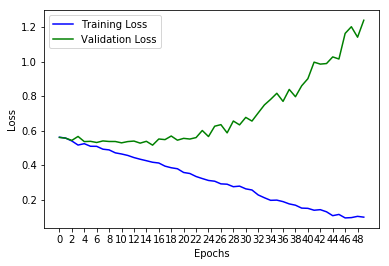

In [77]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,epochs)[0::2])
plt.legend()
plt.show()

<b>Evaluation</b>

In [78]:
y_pred = model6.predict_classes(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test_num, y_pred) # , normalize=True, sample_weight=None
model_test_accuracy_comparisons["Model 6"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test_num, y_pred))
report = metrics.classification_report(y_test_num, y_pred)
model_test_precision_comparisons["Model 6"] = report.split('\n')[-2].split('      ')[1]
model_test_recall_comparisons["Model 6"] = report.split('\n')[-2].split('      ')[2]
model_test_f1_comparisons["Model 6"] = report.split('\n')[-2].split('      ')[3]
print("Confusion Matrix")
pd.crosstab(np.array(y_test_num), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.456305599162742
              precision    recall  f1-score   support

           0       0.70      0.62      0.66       894
           1       0.10      0.57      0.17        60
           2       0.66      0.29      0.41       896
           3       0.06      0.41      0.11        61

   micro avg       0.46      0.46      0.46      1911
   macro avg       0.38      0.47      0.34      1911
weighted avg       0.64      0.46      0.51      1911

Confusion Matrix


Predicted,0,1,2,3,All
True,,,,,
0,551,96,117,130,894
1,11,34,8,7,60
2,201,193,262,240,896
3,19,7,10,25,61
All,782,330,397,402,1911


<b>Persist A Model</b>

In [79]:
filepath = "model6_part1.mod"
model6.save(filepath)

## Task 3

Deploy each of the two models trained to the Lunar Lander Game play 200 episodes and analyse the reward achieved by the models trained using each approach <br/>

1) The lunar_lander_ml_images_player.py and lunar_lander_rl_player.py python scripts contain the code to load a saved model and run iterations of the game using that model.<br/>
2) Write a short document (no more that 350 words) in a Jupyter notebook to describe the results of the experiments.
3) Reflect on the performance of each model. <br/>
4) Reflect on the amount of computation required to train each model

In [93]:
task1_model_reward_comparisons = dict()

In [81]:
!python lunar_lander_ml_images_player_model1.py

Using TensorFlow backend.
2019-04-23 00:09:30.608593: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
['-0.02', '+0.93', '-0.76', '-0.22', '+0.02', '+0.17', '+0.00', '+0.00']
step 0 total_reward -1.11
['-0.17', '+0.78', '-0.76', '-0.75', '+0.19', '+0.17', '+0.00', '+0.00']
step 20 total_reward -32.77
['-0.35', '+0.60', '-1.18', '-0.42', '+0.32', '+0.11', '+0.00', '+0.00']
step 40 total_reward -59.93
['-0.63', '+0.52', '-1.49', '-0.35', '+0.44', '+0.13', '+0.00', '+0.00']
step 60 total_reward -115.32
['-0.93', '+0.33', '-1.49', '-0.89', '+0.57', '+0.13', '+0.00', '+0.00']
step 80 total_reward -165.10
['-1.00', '+0.26', '-1.49', '-1.02', '+0.60', '+0.13', '+0.00', '+0.00']
step 85 total_reward -277.29
['+0.01', '+0.94', '+0.70', '-0.13', '-0.02', '-0.16', '+0.00', '+0.00']
step 0 total_reward -0.93
['+0.15', '+0.81', '+0.70', '-0.66', '-0.17', '-0.16', '+0.00', '+0.00']
step 20 total_reward 

['+0.86', '+0.98', '+1.49', '+0.72', '-0.42', '-0.11', '+0.00', '+0.00']
step 120 total_reward -227.68
['+1.01', '+1.07', '+1.49', '+0.45', '-0.48', '-0.11', '+0.00', '+0.00']
step 130 total_reward -338.59
['+0.00', '+0.95', '+0.19', '+0.40', '-0.00', '-0.04', '+0.00', '+0.00']
step 0 total_reward +1.55
['+0.04', '+0.99', '+0.19', '-0.14', '-0.05', '-0.04', '+0.00', '+0.00']
step 20 total_reward +14.67
['+0.08', '+0.86', '+0.19', '-0.67', '-0.09', '-0.04', '+0.00', '+0.00']
step 40 total_reward -23.77
['+0.12', '+0.62', '+0.28', '-0.76', '-0.11', '-0.02', '+0.00', '+0.00']
step 60 total_reward -17.58
['+0.19', '+0.46', '+0.45', '-0.27', '-0.15', '-0.05', '+0.00', '+0.00']
step 80 total_reward +14.92
['+0.31', '+0.45', '+0.71', '+0.16', '-0.20', '-0.04', '+0.00', '+0.00']
step 100 total_reward -21.85
['+0.48', '+0.56', '+0.97', '+0.45', '-0.24', '-0.06', '+0.00', '+0.00']
step 120 total_reward -84.33
['+0.72', '+0.76', '+1.36', '+0.85', '-0.29', '-0.05', '+0.00', '+0.00']
step 140 total

['-0.91', '+0.90', '-0.90', '-0.79', '+0.35', '+0.03', '+0.00', '+0.00']
step 220 total_reward -169.67
['-1.01', '+0.74', '-0.90', '-1.08', '+0.36', '+0.03', '+0.00', '+0.00']
step 231 total_reward -287.80
['-0.01', '+0.95', '-0.43', '+0.35', '+0.01', '+0.10', '+0.00', '+0.00']
step 0 total_reward +0.70
['-0.09', '+0.97', '-0.43', '-0.18', '+0.11', '+0.10', '+0.00', '+0.00']
step 20 total_reward -2.66
['-0.18', '+0.83', '-0.43', '-0.72', '+0.20', '+0.10', '+0.00', '+0.00']
step 40 total_reward -36.67
['-0.29', '+0.62', '-0.77', '-0.60', '+0.26', '+0.01', '+0.00', '+0.00']
step 60 total_reward -43.48
['-0.48', '+0.49', '-1.14', '-0.31', '+0.27', '+0.02', '+0.00', '+0.00']
step 80 total_reward -72.29
['-0.71', '+0.32', '-1.16', '-0.84', '+0.36', '+0.09', '+0.00', '+0.00']
step 100 total_reward -115.57
['-0.86', '+0.12', '-0.99', '-0.45', '+0.28', '-4.00', '+0.00', '+1.00']
step 113 total_reward -231.06
['-0.00', '+0.93', '-0.24', '-0.48', '+0.01', '+0.05', '+0.00', '+0.00']
step 0 total_

['+0.12', '+1.01', '+0.54', '-0.06', '-0.13', '-0.12', '+0.00', '+0.00']
step 20 total_reward -0.64
['+0.22', '+0.91', '+0.54', '-0.59', '-0.25', '-0.12', '+0.00', '+0.00']
step 40 total_reward -30.50
['+0.35', '+0.70', '+0.79', '-0.61', '-0.38', '-0.14', '+0.00', '+0.00']
step 60 total_reward -50.24
['+0.56', '+0.55', '+1.34', '-0.38', '-0.51', '-0.13', '+0.00', '+0.00']
step 80 total_reward -109.21
['+0.90', '+0.47', '+1.90', '-0.34', '-0.63', '-0.11', '+0.00', '+0.00']
step 100 total_reward -200.86
['+1.02', '+0.43', '+1.90', '-0.50', '-0.66', '-0.11', '+0.00', '+0.00']
step 106 total_reward -313.68
['-0.02', '+0.94', '-0.78', '+0.04', '+0.02', '+0.17', '+0.00', '+0.00']
step 0 total_reward -0.65
['-0.17', '+0.87', '-0.78', '-0.49', '+0.19', '+0.17', '+0.00', '+0.00']
step 20 total_reward -26.61
['-0.34', '+0.69', '-1.05', '-0.46', '+0.36', '+0.17', '+0.00', '+0.00']
step 40 total_reward -58.26
['-0.61', '+0.59', '-1.64', '-0.29', '+0.49', '+0.07', '+0.00', '+0.00']
step 60 total_re

['+0.02', '+0.86', '+0.09', '-0.54', '-0.02', '-0.02', '+0.00', '+0.00']
step 20 total_reward -38.69
['+0.04', '+0.65', '+0.12', '-0.63', '-0.04', '-0.02', '+0.00', '+0.00']
step 40 total_reward -32.68
['+0.07', '+0.52', '+0.20', '-0.26', '-0.08', '-0.02', '+0.00', '+0.00']
step 60 total_reward +1.63
['+0.12', '+0.50', '+0.33', '+0.06', '-0.14', '-0.07', '+0.00', '+0.00']
step 80 total_reward -9.32
['+0.21', '+0.58', '+0.55', '+0.47', '-0.21', '-0.08', '+0.00', '+0.00']
step 100 total_reward -70.98
['+0.35', '+0.79', '+0.95', '+0.95', '-0.29', '-0.08', '+0.00', '+0.00']
step 120 total_reward -173.47
['+0.58', '+1.11', '+1.17', '+0.87', '-0.37', '-0.07', '+0.00', '+0.00']
step 140 total_reward -233.21
['+0.81', '+1.28', '+1.17', '+0.34', '-0.43', '-0.07', '+0.00', '+0.00']
step 160 total_reward -242.79
['+1.01', '+1.31', '+1.17', '-0.12', '-0.49', '-0.07', '+0.00', '+0.00']
step 177 total_reward -356.52
['+0.01', '+0.93', '+0.27', '-0.27', '-0.01', '-0.06', '+0.00', '+0.00']
step 0 tota

['-0.26', '+0.99', '-0.40', '+0.36', '+0.00', '-0.03', '+0.00', '+0.00']
step 180 total_reward -57.22
['-0.34', '+1.02', '-0.40', '-0.17', '-0.03', '-0.03', '+0.00', '+0.00']
step 200 total_reward -53.85
['-0.42', '+0.88', '-0.40', '-0.70', '-0.06', '-0.03', '+0.00', '+0.00']
step 220 total_reward -85.13
['-0.48', '+0.67', '-0.28', '-0.57', '-0.07', '+0.01', '+0.00', '+0.00']
step 240 total_reward -57.89
['-0.53', '+0.54', '-0.21', '-0.42', '-0.05', '+0.02', '+0.00', '+0.00']
step 260 total_reward -38.20
['-0.57', '+0.33', '-0.22', '-0.95', '-0.00', '+0.07', '+0.00', '+0.00']
step 280 total_reward -74.46
['-0.61', '+0.03', '-0.08', '-0.76', '+0.01', '-4.45', '+1.00', '+1.00']
step 297 total_reward -202.94
['-0.01', '+0.93', '-0.47', '-0.52', '+0.01', '+0.11', '+0.00', '+0.00']
step 0 total_reward -1.58
['-0.10', '+0.69', '-0.48', '-0.90', '+0.12', '+0.12', '+0.00', '+0.00']
step 20 total_reward -22.38
['-0.22', '+0.48', '-0.75', '-0.54', '+0.22', '+0.09', '+0.00', '+0.00']
step 40 tota

['-0.86', '+0.77', '-0.71', '-0.97', '+0.08', '-0.01', '+0.00', '+0.00']
step 180 total_reward -158.79
['-1.00', '+0.40', '-0.71', '-1.51', '+0.07', '-0.01', '+0.00', '+0.00']
step 200 total_reward -195.85
['-1.01', '+0.37', '-0.71', '-1.53', '+0.07', '-0.01', '+0.00', '+0.00']
step 201 total_reward -295.85
['+0.02', '+0.93', '+0.80', '-0.33', '-0.02', '-0.18', '+0.00', '+0.00']
step 0 total_reward -1.26
['+0.18', '+0.75', '+0.82', '-0.83', '-0.20', '-0.18', '+0.00', '+0.00']
step 20 total_reward -32.86
['+0.37', '+0.55', '+1.15', '-0.53', '-0.39', '-0.21', '+0.00', '+0.00']
step 40 total_reward -57.64
['+0.65', '+0.43', '+1.79', '-0.29', '-0.61', '-0.21', '+0.00', '+0.00']
step 60 total_reward -151.78
['+1.01', '+0.30', '+1.90', '-0.69', '-0.81', '-0.21', '+0.00', '+0.00']
step 79 total_reward -317.53
['+0.01', '+0.93', '+0.36', '-0.41', '-0.01', '-0.08', '+0.00', '+0.00']
step 0 total_reward -1.66
['+0.08', '+0.72', '+0.38', '-0.82', '-0.09', '-0.07', '+0.00', '+0.00']
step 20 total_

['-0.59', '+0.58', '-1.35', '+0.03', '+0.47', '+0.16', '+0.00', '+0.00']
step 80 total_reward -135.87
['-0.86', '+0.50', '-1.35', '-0.50', '+0.63', '+0.16', '+0.00', '+0.00']
step 100 total_reward -178.15
['-1.01', '+0.40', '-1.35', '-0.79', '+0.72', '+0.16', '+0.00', '+0.00']
step 111 total_reward -305.39
['+0.01', '+0.93', '+0.65', '-0.29', '-0.01', '-0.15', '+0.00', '+0.00']
step 0 total_reward -1.22
['+0.14', '+0.76', '+0.65', '-0.82', '-0.16', '-0.15', '+0.00', '+0.00']
step 20 total_reward -33.70
['+0.30', '+0.57', '+0.96', '-0.50', '-0.32', '-0.15', '+0.00', '+0.00']
step 40 total_reward -44.89
['+0.54', '+0.48', '+1.50', '-0.13', '-0.47', '-0.16', '+0.00', '+0.00']
step 60 total_reward -117.25
['+0.90', '+0.46', '+1.90', '-0.18', '-0.63', '-0.17', '+0.00', '+0.00']
step 80 total_reward -206.50
['+1.01', '+0.44', '+1.90', '-0.34', '-0.68', '-0.17', '+0.00', '+0.00']
step 86 total_reward -320.10
['+0.01', '+0.95', '+0.46', '+0.23', '-0.01', '-0.10', '+0.00', '+0.00']
step 0 total

['+0.00', '+0.87', '+0.01', '-0.49', '-0.00', '-0.00', '+0.00', '+0.00']
step 20 total_reward -35.76
['+0.01', '+0.66', '+0.02', '-0.61', '-0.01', '+0.00', '+0.00', '+0.00']
step 40 total_reward -29.45
['+0.00', '+0.56', '-0.02', '-0.18', '-0.04', '-0.06', '+0.00', '+0.00']
step 60 total_reward +15.06
['+0.01', '+0.55', '+0.09', '+0.20', '-0.07', '-0.02', '+0.00', '+0.00']
step 80 total_reward +2.60
['+0.04', '+0.65', '+0.13', '+0.52', '-0.11', '-0.09', '+0.00', '+0.00']
step 100 total_reward -48.86
['+0.08', '+0.86', '+0.28', '+0.58', '-0.16', '-0.04', '+0.00', '+0.00']
step 120 total_reward -89.91
['+0.14', '+0.95', '+0.28', '+0.05', '-0.20', '-0.04', '+0.00', '+0.00']
step 140 total_reward -67.85
['+0.20', '+0.88', '+0.28', '-0.48', '-0.25', '-0.04', '+0.00', '+0.00']
step 160 total_reward -93.85
['+0.26', '+0.68', '+0.46', '-0.63', '-0.29', '-0.04', '+0.00', '+0.00']
step 180 total_reward -104.76
['+0.40', '+0.55', '+0.91', '-0.26', '-0.29', '+0.01', '+0.00', '+0.00']
step 200 tota

['+0.00', '+0.94', '+0.23', '+0.12', '-0.01', '-0.05', '+0.00', '+0.00']
step 0 total_reward +0.86
['+0.05', '+0.90', '+0.23', '-0.42', '-0.06', '-0.05', '+0.00', '+0.00']
step 20 total_reward -21.30
['+0.10', '+0.70', '+0.22', '-0.74', '-0.11', '-0.10', '+0.00', '+0.00']
step 40 total_reward -38.73
['+0.16', '+0.54', '+0.44', '-0.36', '-0.23', '-0.09', '+0.00', '+0.00']
step 60 total_reward -22.38
['+0.28', '+0.49', '+0.81', '-0.05', '-0.33', '-0.09', '+0.00', '+0.00']
step 80 total_reward -62.59
['+0.49', '+0.54', '+1.40', '+0.35', '-0.42', '-0.06', '+0.00', '+0.00']
step 100 total_reward -157.71
['+0.83', '+0.69', '+1.85', '+0.50', '-0.50', '-0.10', '+0.00', '+0.00']
step 120 total_reward -252.55
['+1.02', '+0.75', '+1.85', '+0.24', '-0.55', '-0.10', '+0.00', '+0.00']
step 130 total_reward -368.17
['+0.01', '+0.95', '+0.74', '+0.27', '-0.02', '-0.17', '+0.00', '+0.00']
step 0 total_reward -0.23
['+0.16', '+0.95', '+0.74', '-0.26', '-0.18', '-0.17', '+0.00', '+0.00']
step 20 total_re

['+0.00', '+0.94', '+0.14', '+0.00', '-0.00', '-0.03', '+0.00', '+0.00']
step 0 total_reward +0.13
['+0.03', '+0.86', '+0.14', '-0.53', '-0.03', '-0.03', '+0.00', '+0.00']
step 20 total_reward -35.72
['+0.06', '+0.65', '+0.20', '-0.63', '-0.06', '-0.01', '+0.00', '+0.00']
step 40 total_reward -31.37
['+0.11', '+0.52', '+0.26', '-0.25', '-0.08', '-0.03', '+0.00', '+0.00']
step 60 total_reward +2.18
['+0.17', '+0.49', '+0.39', '+0.06', '-0.11', '-0.03', '+0.00', '+0.00']
step 80 total_reward -9.22
['+0.27', '+0.57', '+0.58', '+0.45', '-0.14', '-0.01', '+0.00', '+0.00']
step 100 total_reward -62.03
['+0.40', '+0.76', '+0.79', '+0.87', '-0.14', '-0.01', '+0.00', '+0.00']
step 120 total_reward -136.42
['+0.58', '+1.05', '+0.94', '+0.81', '-0.11', '+0.04', '+0.00', '+0.00']
step 140 total_reward -176.92
['+0.77', '+1.21', '+0.94', '+0.28', '-0.07', '+0.04', '+0.00', '+0.00']
step 160 total_reward -170.04
['+0.96', '+1.21', '+0.94', '-0.26', '-0.03', '+0.04', '+0.00', '+0.00']
step 180 total_

['-0.70', '+0.14', '-1.10', '-0.50', '+0.55', '-3.20', '+0.00', '+1.00']
step 98 total_reward -241.35
['-0.01', '+0.93', '-0.63', '-0.34', '+0.01', '+0.14', '+0.00', '+0.00']
step 0 total_reward -1.31
['-0.14', '+0.75', '-0.63', '-0.80', '+0.16', '+0.16', '+0.00', '+0.00']
step 20 total_reward -29.23
['-0.29', '+0.55', '-0.90', '-0.55', '+0.32', '+0.17', '+0.00', '+0.00']
step 40 total_reward -40.30
['-0.51', '+0.43', '-1.25', '-0.48', '+0.52', '+0.26', '+0.00', '+0.00']
step 60 total_reward -98.25
['-0.76', '+0.20', '-1.25', '-1.01', '+0.78', '+0.26', '+0.00', '+0.00']
step 80 total_reward -162.80
['-0.87', '+0.06', '-0.07', '+0.10', '+1.22', '+0.48', '+0.00', '+1.00']
step 90 total_reward -255.18
['-0.00', '+0.94', '-0.10', '-0.09', '+0.00', '+0.02', '+0.00', '+0.00']
step 0 total_reward -1.51
['-0.02', '+0.83', '-0.10', '-0.62', '+0.03', '+0.02', '+0.00', '+0.00']
step 20 total_reward -42.30
['-0.05', '+0.63', '-0.17', '-0.51', '+0.03', '-0.01', '+0.00', '+0.00']
step 40 total_rewar

['+0.48', '+0.60', '+1.06', '+0.60', '-0.17', '-0.01', '+0.00', '+0.00']
step 100 total_reward -121.96
['+0.71', '+0.84', '+1.28', '+0.97', '-0.20', '-0.04', '+0.00', '+0.00']
step 120 total_reward -202.55
['+0.96', '+1.05', '+1.28', '+0.44', '-0.24', '-0.04', '+0.00', '+0.00']
step 140 total_reward -213.34
['+1.00', '+1.07', '+1.28', '+0.36', '-0.24', '-0.04', '+0.00', '+0.00']
step 143 total_reward -314.69
['-0.01', '+0.93', '-0.29', '-0.49', '+0.01', '+0.07', '+0.00', '+0.00']
step 0 total_reward -1.76
['-0.06', '+0.70', '-0.27', '-0.87', '+0.08', '+0.11', '+0.00', '+0.00']
step 20 total_reward -21.99
['-0.13', '+0.48', '-0.40', '-0.58', '+0.19', '+0.13', '+0.00', '+0.00']
step 40 total_reward +1.67
['-0.24', '+0.35', '-0.72', '-0.29', '+0.33', '+0.14', '+0.00', '+0.00']
step 60 total_reward -17.30
['-0.42', '+0.30', '-1.17', '-0.07', '+0.47', '+0.15', '+0.00', '+0.00']
step 80 total_reward -86.21
['-0.68', '+0.24', '-1.34', '-0.42', '+0.62', '+0.14', '+0.00', '+0.00']
step 100 tota

['-0.24', '+0.62', '-0.77', '-0.57', '+0.24', '+0.07', '+0.00', '+0.00']
step 40 total_reward -42.06
['-0.43', '+0.52', '-1.11', '-0.15', '+0.31', '+0.11', '+0.00', '+0.00']
step 60 total_reward -72.78
['-0.68', '+0.49', '-1.31', '-0.31', '+0.49', '+0.22', '+0.00', '+0.00']
step 80 total_reward -130.63
['-0.94', '+0.31', '-1.31', '-0.84', '+0.71', '+0.22', '+0.00', '+0.00']
step 100 total_reward -189.28
['-1.01', '+0.24', '-1.31', '-0.98', '+0.76', '+0.22', '+0.00', '+0.00']
step 105 total_reward -303.17
['+0.01', '+0.93', '+0.36', '-0.38', '-0.01', '-0.08', '+0.00', '+0.00']
step 0 total_reward -1.63
['+0.08', '+0.73', '+0.35', '-0.84', '-0.09', '-0.10', '+0.00', '+0.00']
step 20 total_reward -29.98
['+0.16', '+0.54', '+0.54', '-0.47', '-0.23', '-0.13', '+0.00', '+0.00']
step 40 total_reward -12.70
['+0.31', '+0.44', '+0.97', '-0.16', '-0.33', '-0.07', '+0.00', '+0.00']
step 60 total_reward -53.27
['+0.56', '+0.45', '+1.44', '+0.20', '-0.40', '-0.10', '+0.00', '+0.00']
step 80 total_r

['+0.00', '+0.95', '+0.02', '+0.15', '-0.00', '-0.01', '+0.00', '+0.00']
step 0 total_reward +2.29
['+0.01', '+0.91', '+0.02', '-0.38', '-0.01', '-0.01', '+0.00', '+0.00']
step 20 total_reward -17.46
['+0.01', '+0.71', '+0.04', '-0.81', '-0.01', '+0.01', '+0.00', '+0.00']
step 40 total_reward -41.28
['+0.02', '+0.55', '-0.01', '-0.28', '-0.02', '-0.06', '+0.00', '+0.00']
step 60 total_reward +20.47
['+0.03', '+0.54', '+0.12', '+0.22', '-0.04', '+0.01', '+0.00', '+0.00']
step 80 total_reward +16.43
['+0.06', '+0.66', '+0.25', '+0.61', '-0.01', '+0.09', '+0.00', '+0.00']
step 100 total_reward -39.35
['+0.11', '+0.86', '+0.22', '+0.53', '+0.06', '+0.07', '+0.00', '+0.00']
step 120 total_reward -59.81
['+0.15', '+0.94', '+0.22', '-0.01', '+0.13', '+0.07', '+0.00', '+0.00']
step 140 total_reward -39.61
['+0.20', '+0.85', '+0.22', '-0.54', '+0.19', '+0.07', '+0.00', '+0.00']
step 160 total_reward -74.77
['+0.24', '+0.65', '+0.04', '-0.54', '+0.26', '+0.08', '+0.00', '+0.00']
step 180 total_r

['+0.01', '+0.95', '+0.69', '+0.24', '-0.02', '-0.15', '+0.00', '+0.00']
step 0 total_reward -0.18
['+0.15', '+0.94', '+0.69', '-0.30', '-0.17', '-0.15', '+0.00', '+0.00']
step 20 total_reward -17.74
['+0.29', '+0.77', '+0.76', '-0.68', '-0.32', '-0.16', '+0.00', '+0.00']
step 40 total_reward -48.19
['+0.49', '+0.62', '+1.22', '-0.40', '-0.52', '-0.21', '+0.00', '+0.00']
step 60 total_reward -96.73
['+0.82', '+0.53', '+1.90', '-0.31', '-0.67', '-0.15', '+0.00', '+0.00']
step 80 total_reward -199.42
['+1.00', '+0.47', '+1.90', '-0.57', '-0.74', '-0.15', '+0.00', '+0.00']
step 90 total_reward -323.52
['+0.00', '+0.95', '+0.12', '+0.45', '-0.00', '-0.03', '+0.00', '+0.00']
step 0 total_reward +1.68
['+0.03', '+1.01', '+0.12', '-0.08', '-0.03', '-0.03', '+0.00', '+0.00']
step 20 total_reward +25.42
['+0.05', '+0.90', '+0.12', '-0.62', '-0.06', '-0.03', '+0.00', '+0.00']
step 40 total_reward -14.62
['+0.08', '+0.65', '+0.16', '-0.78', '-0.09', '-0.04', '+0.00', '+0.00']
step 60 total_reward

['+0.89', '+0.66', '+1.78', '+0.17', '-0.60', '-0.11', '+0.00', '+0.00']
step 120 total_reward -254.16
['+1.01', '+0.67', '+1.78', '-0.01', '-0.64', '-0.11', '+0.00', '+0.00']
step 127 total_reward -365.88
['-0.00', '+0.93', '-0.24', '-0.49', '+0.01', '+0.05', '+0.00', '+0.00']
step 0 total_reward -1.81
['-0.05', '+0.70', '-0.28', '-0.88', '+0.06', '+0.03', '+0.00', '+0.00']
step 20 total_reward -23.35
['-0.11', '+0.50', '-0.35', '-0.49', '+0.15', '+0.10', '+0.00', '+0.00']
step 40 total_reward +12.44
['-0.21', '+0.41', '-0.64', '-0.12', '+0.21', '+0.05', '+0.00', '+0.00']
step 60 total_reward +0.81
['-0.38', '+0.45', '-0.98', '+0.25', '+0.26', '+0.18', '+0.00', '+0.00']
step 80 total_reward -59.00
['-0.58', '+0.44', '-1.09', '-0.31', '+0.79', '+0.64', '+0.00', '+0.00']
step 100 total_reward -137.58
['-0.80', '+0.27', '-1.09', '-0.85', '+1.43', '+0.64', '+0.00', '+0.00']
step 120 total_reward -237.18
['-0.88', '+0.17', '+0.07', '-0.04', '+1.64', '-0.27', '+0.00', '+1.00']
step 128 tota

['+1.00', '+0.50', '+1.52', '-0.20', '-0.36', '-0.07', '+0.00', '+0.00']
step 94 total_reward -245.18
['+0.02', '+0.94', '+0.80', '+0.09', '-0.02', '-0.18', '+0.00', '+0.00']
step 0 total_reward -0.61
['+0.17', '+0.89', '+0.80', '-0.45', '-0.20', '-0.18', '+0.00', '+0.00']
step 20 total_reward -25.59
['+0.34', '+0.69', '+0.98', '-0.57', '-0.38', '-0.21', '+0.00', '+0.00']
step 40 total_reward -55.10
['+0.60', '+0.57', '+1.64', '-0.25', '-0.58', '-0.21', '+0.00', '+0.00']
step 60 total_reward -139.90
['+0.98', '+0.50', '+1.97', '-0.43', '-0.84', '-0.26', '+0.00', '+0.00']
step 80 total_reward -230.07
['+1.02', '+0.49', '+1.97', '-0.48', '-0.86', '-0.26', '+0.00', '+0.00']
step 82 total_reward -333.39
['-0.01', '+0.94', '-0.71', '-0.19', '+0.02', '+0.16', '+0.00', '+0.00']
step 0 total_reward -1.05
['-0.16', '+0.79', '-0.71', '-0.73', '+0.18', '+0.16', '+0.00', '+0.00']
step 20 total_reward -32.25
['-0.33', '+0.60', '-1.09', '-0.47', '+0.30', '+0.09', '+0.00', '+0.00']
step 40 total_rewa

['+0.01', '+0.93', '+0.57', '-0.42', '-0.01', '-0.13', '+0.00', '+0.00']
step 0 total_reward -1.44
['+0.12', '+0.72', '+0.58', '-0.89', '-0.14', '-0.13', '+0.00', '+0.00']
step 20 total_reward -30.69
['+0.26', '+0.51', '+0.79', '-0.58', '-0.28', '-0.17', '+0.00', '+0.00']
step 40 total_reward -26.16
['+0.46', '+0.40', '+1.24', '-0.17', '-0.51', '-0.27', '+0.00', '+0.00']
step 60 total_reward -85.83
['+0.77', '+0.37', '+1.76', '-0.16', '-0.77', '-0.29', '+0.00', '+0.00']
step 80 total_reward -194.15
['+1.00', '+0.30', '+1.76', '-0.51', '-0.96', '-0.29', '+0.00', '+0.00']
step 93 total_reward -334.53
['+0.00', '+0.95', '+0.21', '+0.27', '-0.00', '-0.05', '+0.00', '+0.00']
step 0 total_reward +1.46
['+0.04', '+0.95', '+0.21', '-0.26', '-0.05', '-0.05', '+0.00', '+0.00']
step 20 total_reward -1.89
['+0.09', '+0.79', '+0.21', '-0.79', '-0.10', '-0.05', '+0.00', '+0.00']
step 40 total_reward -39.52
['+0.14', '+0.58', '+0.31', '-0.49', '-0.15', '-0.09', '+0.00', '+0.00']
step 60 total_reward 

['+0.89', '+0.66', '+1.59', '+0.18', '-0.46', '-0.09', '+0.00', '+0.00']
step 120 total_reward -207.79
['+1.01', '+0.67', '+1.59', '-0.03', '-0.50', '-0.09', '+0.00', '+0.00']
step 128 total_reward -319.50
['-0.01', '+0.96', '-0.73', '+0.48', '+0.02', '+0.16', '+0.00', '+0.00']
step 0 total_reward -0.04
['-0.16', '+1.02', '-0.74', '-0.05', '+0.18', '+0.16', '+0.00', '+0.00']
step 20 total_reward -9.60
['-0.31', '+0.92', '-0.74', '-0.59', '+0.35', '+0.16', '+0.00', '+0.00']
step 40 total_reward -40.09
['-0.47', '+0.70', '-1.02', '-0.68', '+0.52', '+0.21', '+0.00', '+0.00']
step 60 total_reward -77.09
['-0.74', '+0.51', '-1.42', '-0.83', '+0.70', '+0.16', '+0.00', '+0.00']
step 80 total_reward -145.90
['-1.00', '+0.20', '-1.42', '-1.34', '+0.86', '+0.16', '+0.00', '+0.00']
step 99 total_reward -301.22
['+0.01', '+0.95', '+0.66', '+0.29', '-0.01', '-0.15', '+0.00', '+0.00']
step 0 total_reward -0.02
['+0.14', '+0.95', '+0.66', '-0.24', '-0.16', '-0.15', '+0.00', '+0.00']
step 20 total_rew

In [94]:
task1_model_reward_comparisons["Model 1"] = '-314.5653621855106'

In [83]:
!python lunar_lander_ml_images_player_model2.py

Using TensorFlow backend.
2019-04-23 00:23:54.768592: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
['+0.02', '+0.93', '+0.79', '-0.46', '-0.02', '-0.21', '+0.00', '+0.00']
step 0 total_reward -2.23
['+0.16', '+0.71', '+0.73', '-0.84', '-0.03', '-0.01', '+0.00', '+0.00']
step 20 total_reward -4.63
['+0.32', '+0.41', '+0.90', '-1.26', '-0.32', '-0.65', '+0.00', '+0.00']
step 40 total_reward -58.28
['+0.50', '-0.01', '+0.63', '+0.42', '-1.59', '-2.68', '+1.00', '+0.00']
step 59 total_reward -297.34
['-0.00', '+0.95', '-0.07', '+0.16', '+0.00', '+0.06', '+0.00', '+0.00']
step 0 total_reward +1.50
['-0.02', '+0.91', '-0.14', '-0.37', '+0.19', '+0.33', '+0.00', '+0.00']
step 20 total_reward -36.33
['-0.04', '+0.72', '-0.19', '-0.71', '+0.42', '+0.23', '+0.00', '+0.00']
step 40 total_reward -76.14
['-0.14', '+0.54', '-0.73', '-0.67', '+0.70', '+0.47', '+0.00', '+0.00']
step 60 total_reward -11

['-0.00', '+0.94', '-0.22', '+0.02', '+0.01', '+0.08', '+0.00', '+0.00']
step 0 total_reward -0.87
['-0.06', '+0.86', '-0.28', '-0.51', '+0.30', '+0.28', '+0.00', '+0.00']
step 20 total_reward -58.25
['-0.12', '+0.65', '-0.52', '-0.79', '+0.57', '+0.31', '+0.00', '+0.00']
step 40 total_reward -103.95
['-0.24', '+0.32', '-0.81', '-1.37', '+1.37', '+1.17', '+0.00', '+0.00']
step 60 total_reward -224.41
['-0.42', '-0.03', '-0.34', '-0.09', '+2.25', '+3.58', '+0.00', '+0.00']
step 76 total_reward -452.68
['-0.01', '+0.93', '-0.45', '-0.46', '+0.01', '+0.14', '+0.00', '+0.00']
step 0 total_reward -2.68
['-0.10', '+0.72', '-0.57', '-0.76', '+0.28', '+0.26', '+0.00', '+0.00']
step 20 total_reward -41.13
['-0.24', '+0.47', '-0.81', '-1.08', '+0.76', '+0.87', '+0.00', '+0.00']
step 40 total_reward -113.06
['-0.46', '+0.08', '-1.34', '-1.51', '+1.84', '+0.83', '+0.00', '+0.00']
step 60 total_reward -282.70
['-0.50', '+0.03', '-1.73', '-0.23', '+2.29', '+1.54', '+0.00', '+0.00']
step 63 total_rew

['+0.23', '+0.90', '+0.65', '-0.65', '-1.83', '-1.27', '+0.00', '+0.00']
step 40 total_reward -210.66
['+0.37', '+0.58', '+0.72', '-1.54', '-3.48', '-1.85', '+0.00', '+0.00']
step 60 total_reward -432.07
['+0.51', '+0.06', '+0.70', '-1.32', '-5.80', '-3.03', '+0.00', '+0.00']
step 80 total_reward -626.85
['+0.52', '+0.04', '+0.68', '-0.82', '-6.10', '-6.44', '+1.00', '+0.00']
step 81 total_reward -726.85
['-0.00', '+0.93', '-0.24', '-0.31', '+0.01', '+0.09', '+0.00', '+0.00']
step 0 total_reward -2.53
['-0.05', '+0.76', '-0.18', '-0.74', '-0.06', '-0.10', '+0.00', '+0.00']
step 20 total_reward -28.15
['-0.07', '+0.60', '-0.07', '-0.26', '-0.19', '-0.17', '+0.00', '+0.00']
step 40 total_reward +17.67
['-0.04', '+0.59', '+0.36', '+0.13', '-0.33', '-0.12', '+0.00', '+0.00']
step 60 total_reward -12.25
['+0.09', '+0.69', '+0.92', '+0.49', '-0.42', '-0.08', '+0.00', '+0.00']
step 80 total_reward -103.21
['+0.33', '+0.88', '+1.53', '+0.80', '-0.52', '-0.10', '+0.00', '+0.00']
step 100 total_

['+0.12', '+0.76', '+0.49', '-0.83', '+0.24', '+0.41', '+0.00', '+0.00']
step 20 total_reward -34.89
['+0.22', '+0.46', '+0.58', '-1.23', '+0.37', '-0.24', '+0.00', '+0.00']
step 40 total_reward -62.84
['+0.35', '+0.01', '+0.63', '-1.74', '-0.13', '-0.45', '+0.00', '+0.00']
step 60 total_reward -72.31
['+0.37', '-0.09', '+1.00', '-0.17', '-0.33', '+0.38', '+1.00', '+1.00']
step 64 total_reward -166.60
['-0.01', '+0.92', '-0.35', '-0.57', '+0.01', '+0.12', '+0.00', '+0.00']
step 0 total_reward -2.53
['-0.08', '+0.68', '-0.40', '-0.80', '+0.14', '+0.11', '+0.00', '+0.00']
step 20 total_reward -16.75
['-0.17', '+0.41', '-0.58', '-1.17', '+0.55', '+0.79', '+0.00', '+0.00']
step 40 total_reward -76.25
['-0.31', '+0.02', '-1.02', '-0.91', '+1.54', '+3.82', '+0.00', '+1.00']
step 60 total_reward -160.06
['-0.36', '-0.01', '-1.11', '+0.04', '+2.21', '+1.73', '+0.00', '+1.00']
step 64 total_reward -322.16
['+0.00', '+0.94', '+0.20', '-0.06', '-0.00', '-0.01', '+0.00', '+0.00']
step 0 total_rewa

['-0.33', '+0.72', '-1.25', '-0.54', '+0.79', '+0.36', '+0.00', '+0.00']
step 40 total_reward -136.04
['-0.70', '+0.56', '-2.46', '-0.57', '+1.14', '+0.37', '+0.00', '+0.00']
step 60 total_reward -302.11
['-1.00', '+0.43', '-2.56', '-0.93', '+1.53', '+0.92', '+0.00', '+0.00']
step 72 total_reward -473.69
['+0.00', '+0.93', '+0.23', '-0.34', '-0.00', '-0.02', '+0.00', '+0.00']
step 0 total_reward -1.24
['+0.04', '+0.75', '+0.11', '-0.87', '+0.32', '+0.43', '+0.00', '+0.00']
step 20 total_reward -61.95
['+0.03', '+0.49', '-0.01', '-1.03', '+0.56', '-0.13', '+0.00', '+0.00']
step 40 total_reward -78.45
['-0.01', '+0.16', '-0.30', '-1.20', '+0.28', '-0.31', '+0.00', '+0.00']
step 60 total_reward -40.50
['-0.05', '-0.03', '-0.27', '+0.00', '-0.00', '+0.00', '+1.00', '+1.00']
step 71 total_reward -97.95
['+0.00', '+0.92', '+0.08', '-0.55', '-0.00', '+0.02', '+0.00', '+0.00']
step 0 total_reward -1.44
['+0.01', '+0.68', '-0.04', '-0.93', '+0.29', '+0.37', '+0.00', '+0.00']
step 20 total_rewar

['-0.19', '+0.25', '-0.31', '-0.93', '+0.02', '+0.62', '+0.00', '+0.00']
step 60 total_reward +16.17
['-0.23', '-0.04', '-0.58', '-0.34', '+0.39', '+3.22', '+1.00', '+1.00']
step 78 total_reward -128.29
['-0.00', '+0.94', '-0.05', '+0.11', '-0.00', '-0.02', '+0.00', '+0.00']
step 0 total_reward +2.52
['+0.00', '+0.89', '+0.14', '-0.44', '-0.41', '-0.77', '+0.00', '+0.00']
step 20 total_reward -68.54
['+0.04', '+0.68', '+0.42', '-0.93', '-1.35', '-1.01', '+0.00', '+0.00']
step 40 total_reward -197.70
['+0.13', '+0.31', '+0.35', '-1.60', '-2.87', '-1.92', '+0.00', '+0.00']
step 60 total_reward -378.32
['+0.18', '+0.01', '+0.42', '+0.00', '-3.97', '-1.26', '+0.00', '+1.00']
step 72 total_reward -595.53
['-0.01', '+0.94', '-0.36', '-0.11', '+0.01', '+0.04', '+0.00', '+0.00']
step 0 total_reward +0.24
['-0.06', '+0.82', '-0.21', '-0.65', '-0.34', '-0.53', '+0.00', '+0.00']
step 20 total_reward -53.27
['-0.05', '+0.63', '+0.50', '-0.56', '-0.86', '-0.51', '+0.00', '+0.00']
step 40 total_rewa

['-0.01', '+1.01', '+0.06', '-0.07', '-0.40', '-0.75', '+0.00', '+0.00']
step 20 total_reward -5.42
['+0.01', '+0.90', '+0.17', '-0.71', '-1.62', '-1.66', '+0.00', '+0.00']
step 40 total_reward -180.10
['+0.06', '+0.60', '+0.20', '-1.36', '-3.35', '-1.89', '+0.00', '+0.00']
step 60 total_reward -389.34
['+0.09', '+0.10', '+0.15', '-1.83', '-5.63', '-2.47', '+0.00', '+0.00']
step 80 total_reward -617.07
['+0.09', '-0.03', '+0.01', '+0.00', '-6.28', '+0.00', '+1.00', '+1.00']
step 85 total_reward -756.13
['+0.00', '+0.93', '+0.15', '-0.53', '-0.01', '-0.07', '+0.00', '+0.00']
step 0 total_reward -2.38
['+0.04', '+0.69', '+0.28', '-0.93', '-0.35', '-0.42', '+0.00', '+0.00']
step 20 total_reward -56.82
['+0.12', '+0.35', '+0.53', '-1.43', '-1.12', '-1.16', '+0.00', '+0.00']
step 40 total_reward -158.36
['+0.23', '+0.00', '+0.56', '-0.31', '-1.97', '+3.72', '+1.00', '+0.00']
step 55 total_reward -364.22
['-0.01', '+0.93', '-0.75', '-0.26', '+0.02', '+0.14', '+0.00', '+0.00']
step 0 total_re

['+0.43', '+0.06', '-0.07', '-0.26', '-0.25', '+2.97', '+1.00', '+0.00']
step 82 total_reward -138.58
['-0.00', '+0.94', '-0.07', '+0.08', '+0.00', '+0.06', '+0.00', '+0.00']
step 0 total_reward +0.83
['-0.00', '+0.88', '+0.09', '-0.46', '-0.27', '-0.57', '+0.00', '+0.00']
step 20 total_reward -56.78
['+0.03', '+0.67', '+0.49', '-0.80', '-0.95', '-0.66', '+0.00', '+0.00']
step 40 total_reward -152.81
['+0.16', '+0.36', '+0.66', '-1.38', '-1.97', '-1.48', '+0.00', '+0.00']
step 60 total_reward -287.30
['+0.25', '+0.03', '-0.38', '-0.49', '-3.11', '+3.94', '+0.00', '+0.00']
step 74 total_reward -515.08
['-0.01', '+0.94', '-0.28', '+0.03', '+0.01', '+0.11', '+0.00', '+0.00']
step 0 total_reward -1.28
['-0.08', '+0.87', '-0.43', '-0.51', '+0.51', '+0.68', '+0.00', '+0.00']
step 20 total_reward -82.54
['-0.21', '+0.66', '-1.20', '-0.74', '+1.16', '+0.62', '+0.00', '+0.00']
step 40 total_reward -208.73
['-0.48', '+0.37', '-1.36', '-1.32', '+2.16', '+1.46', '+0.00', '+0.00']
step 60 total_rew

['+0.30', '-0.07', '+1.14', '-0.33', '-0.41', '+0.00', '+1.00', '+1.00']
step 79 total_reward -190.12
['-0.01', '+0.95', '-0.36', '+0.32', '+0.01', '+0.12', '+0.00', '+0.00']
step 0 total_reward +0.05
['-0.09', '+0.96', '-0.55', '-0.23', '+0.53', '+0.89', '+0.00', '+0.00']
step 20 total_reward -65.44
['-0.19', '+0.82', '-0.47', '-0.74', '+1.05', '+0.53', '+0.00', '+0.00']
step 40 total_reward -133.98
['-0.33', '+0.53', '-0.75', '-1.32', '+1.91', '+1.29', '+0.00', '+0.00']
step 60 total_reward -262.84
['-0.47', '+0.09', '-1.05', '-0.13', '+3.32', '+0.00', '+0.00', '+0.00']
step 78 total_reward -545.40
['-0.01', '+0.95', '-0.38', '+0.15', '+0.01', '+0.13', '+0.00', '+0.00']
step 0 total_reward -0.85
['-0.09', '+0.91', '-0.39', '-0.37', '+0.36', '+0.16', '+0.00', '+0.00']
step 20 total_reward -46.20
['-0.17', '+0.74', '-0.45', '-0.61', '+0.34', '-0.00', '+0.00', '+0.00']
step 40 total_reward -52.43
['-0.28', '+0.53', '-0.67', '-0.92', '+0.59', '+0.60', '+0.00', '+0.00']
step 60 total_rewa

['-0.95', '+0.01', '-1.37', '-0.06', '+3.62', '-2.06', '+0.00', '+0.00']
step 77 total_reward -663.37
['+0.01', '+0.94', '+0.64', '-0.17', '-0.01', '-0.11', '+0.00', '+0.00']
step 0 total_reward +0.10
['+0.12', '+0.80', '+0.46', '-0.71', '+0.30', '+0.59', '+0.00', '+0.00']
step 20 total_reward -35.23
['+0.21', '+0.54', '+0.47', '-1.07', '+0.73', '+0.08', '+0.00', '+0.00']
step 40 total_reward -88.59
['+0.32', '+0.14', '+0.57', '-1.55', '+0.40', '-0.50', '+0.00', '+0.00']
step 60 total_reward -81.71
['+0.36', '-0.05', '+0.90', '-0.84', '-0.06', '-5.96', '+0.00', '+1.00']
step 68 total_reward -169.05
['+0.01', '+0.94', '+0.63', '+0.03', '-0.01', '-0.11', '+0.00', '+0.00']
step 0 total_reward +0.56
['+0.12', '+0.87', '+0.43', '-0.51', '+0.31', '+0.71', '+0.00', '+0.00']
step 20 total_reward -26.82
['+0.18', '+0.65', '-0.09', '-0.80', '+1.16', '+0.87', '+0.00', '+0.00']
step 40 total_reward -108.66
['+0.17', '+0.35', '-0.11', '-1.22', '+1.52', '-0.04', '+0.00', '+0.00']
step 60 total_rewar

['-0.28', '+0.19', '-1.16', '-1.22', '+1.45', '+0.87', '+0.00', '+0.00']
step 60 total_reward -217.31
['-0.39', '+0.02', '-0.65', '+0.20', '+2.02', '+2.15', '+0.00', '+1.00']
step 70 total_reward -353.88
['+0.02', '+0.94', '+0.76', '+0.06', '-0.02', '-0.14', '+0.00', '+0.00']
step 0 total_reward +0.32
['+0.15', '+0.88', '+0.56', '-0.48', '+0.25', '+0.66', '+0.00', '+0.00']
step 20 total_reward -15.87
['+0.24', '+0.68', '+0.14', '-0.75', '+0.98', '+0.65', '+0.00', '+0.00']
step 40 total_reward -76.38
['+0.28', '+0.39', '+0.23', '-1.15', '+1.09', '-0.35', '+0.00', '+0.00']
step 60 total_reward -106.28
['+0.32', '-0.00', '+0.28', '-0.53', '+0.42', '-5.34', '+0.00', '+1.00']
step 79 total_reward -164.99
['-0.01', '+0.94', '-0.33', '+0.04', '+0.01', '+0.11', '+0.00', '+0.00']
step 0 total_reward -1.20
['-0.05', '+0.87', '-0.14', '-0.50', '-0.29', '-0.67', '+0.00', '+0.00']
step 20 total_reward -41.21
['-0.06', '+0.67', '+0.35', '-0.68', '-0.97', '-0.70', '+0.00', '+0.00']
step 40 total_rewa

['+0.31', '+0.07', '-0.26', '-0.39', '-2.94', '+3.27', '+0.00', '+0.00']
step 78 total_reward -503.80
['-0.01', '+0.92', '-0.70', '-0.58', '+0.01', '+0.11', '+0.00', '+0.00']
step 0 total_reward -0.40
['-0.14', '+0.69', '-0.60', '-0.74', '-0.10', '-0.16', '+0.00', '+0.00']
step 20 total_reward +5.63
['-0.26', '+0.46', '-0.67', '-0.87', '-0.08', '+0.24', '+0.00', '+0.00']
step 40 total_reward +7.85
['-0.41', '+0.13', '-0.70', '-1.30', '+0.35', '+0.23', '+0.00', '+0.00']
step 60 total_reward -47.65
['-0.44', '-0.01', '+0.13', '-0.58', '-0.07', '-4.94', '+0.00', '+1.00']
step 68 total_reward -54.34
['-0.01', '+0.92', '-0.73', '-0.58', '+0.01', '+0.12', '+0.00', '+0.00']
step 0 total_reward -0.43
['-0.15', '+0.68', '-0.60', '-0.82', '-0.13', '-0.20', '+0.00', '+0.00']
step 20 total_reward +0.32
['-0.29', '+0.35', '-0.80', '-1.34', '+0.10', '+0.60', '+0.00', '+0.00']
step 40 total_reward -27.64
['-0.39', '+0.09', '-0.15', '-0.28', '+0.30', '-3.81', '+0.00', '+1.00']
step 53 total_reward -13

['-0.24', '+0.50', '+0.08', '-1.07', '-1.68', '-0.15', '+0.00', '+0.00']
step 60 total_reward -157.44
['-0.17', '+0.11', '+0.66', '-1.60', '-1.54', '+0.03', '+0.00', '+0.00']
step 80 total_reward -176.19
['-0.14', '+0.00', '+0.73', '+0.11', '-2.01', '-1.38', '+0.00', '+0.00']
step 85 total_reward -269.65
['+0.01', '+0.95', '+0.29', '+0.18', '-0.01', '-0.03', '+0.00', '+0.00']
step 0 total_reward +1.67
['+0.05', '+0.91', '+0.09', '-0.37', '+0.39', '+0.79', '+0.00', '+0.00']
step 20 total_reward -38.85
['+0.06', '+0.72', '+0.04', '-0.93', '+1.39', '+1.02', '+0.00', '+0.00']
step 40 total_reward -173.80
['+0.02', '+0.39', '-0.45', '-1.41', '+2.04', '+0.35', '+0.00', '+0.00']
step 60 total_reward -262.23
['-0.11', '+0.01', '-0.88', '+0.01', '+2.27', '+0.37', '+0.00', '+1.00']
step 75 total_reward -456.95
['+0.01', '+0.94', '+0.48', '-0.04', '-0.01', '-0.15', '+0.00', '+0.00']
step 0 total_reward -1.81
['+0.12', '+0.84', '+0.68', '-0.61', '-0.60', '-0.97', '+0.00', '+0.00']
step 20 total_re

['-0.12', '+0.65', '+0.16', '-0.74', '-0.92', '-0.51', '+0.00', '+0.00']
step 40 total_reward -95.60
['-0.09', '+0.36', '+0.06', '-1.17', '-0.94', '+0.40', '+0.00', '+0.00']
step 60 total_reward -110.61
['-0.05', '-0.01', '+0.22', '-0.33', '-0.45', '+3.79', '+1.00', '+0.00']
step 79 total_reward -137.01
['-0.01', '+0.93', '-0.60', '-0.27', '+0.01', '+0.09', '+0.00', '+0.00']
step 0 total_reward -0.03
['-0.12', '+0.77', '-0.56', '-0.75', '-0.09', '-0.14', '+0.00', '+0.00']
step 20 total_reward -19.81
['-0.22', '+0.63', '-0.35', '-0.26', '-0.26', '-0.18', '+0.00', '+0.00']
step 40 total_reward +18.13
['-0.24', '+0.62', '+0.13', '+0.21', '-0.46', '-0.24', '+0.00', '+0.00']
step 60 total_reward +10.38
['-0.15', '+0.73', '+0.85', '+0.47', '-0.70', '-0.28', '+0.00', '+0.00']
step 80 total_reward -100.83
['+0.07', '+0.86', '+1.16', '+0.18', '-1.00', '-0.30', '+0.00', '+0.00']
step 100 total_reward -163.15
['+0.31', '+0.83', '+1.41', '-0.29', '-1.30', '-0.31', '+0.00', '+0.00']
step 120 total_

In [95]:
task1_model_reward_comparisons["Model 2"] = '-371.15323528526295'

In [85]:
!python lunar_lander_ml_images_player_model3.py

Using TensorFlow backend.
2019-04-23 00:30:55.980552: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
['+0.00', '+0.94', '+0.01', '-0.09', '+0.00', '+0.04', '+0.00', '+0.00']
step 0 total_reward -2.42
['-0.02', '+0.83', '-0.16', '-0.64', '+0.47', '+0.71', '+0.00', '+0.00']
step 20 total_reward -95.53
['-0.10', '+0.63', '-0.93', '-0.61', '+1.02', '+0.53', '+0.00', '+0.00']
step 40 total_reward -181.50
['-0.39', '+0.42', '-1.61', '-1.00', '+1.70', '+1.01', '+0.00', '+0.00']
step 60 total_reward -324.11
['-0.66', '+0.10', '-1.95', '-0.55', '+2.84', '+3.78', '+0.00', '+0.00']
step 77 total_reward -567.25
['+0.00', '+0.93', '+0.19', '-0.23', '-0.00', '-0.00', '+0.00', '+0.00']
step 0 total_reward -0.78
['+0.03', '+0.78', '-0.00', '-0.78', '+0.41', '+0.80', '+0.00', '+0.00']
step 20 total_reward -75.12
['-0.04', '+0.56', '-0.86', '-0.75', '+1.18', '+0.77', '+0.00', '+0.00']
step 40 total_reward 

['-0.63', '+0.02', '-0.14', '+0.05', '+3.45', '+0.49', '+0.00', '+0.00']
step 88 total_reward -593.24
['+0.01', '+0.93', '+0.44', '-0.42', '-0.01', '-0.06', '+0.00', '+0.00']
step 0 total_reward -0.74
['+0.08', '+0.72', '+0.38', '-0.95', '+0.21', '+0.15', '+0.00', '+0.00']
step 20 total_reward -42.99
['+0.18', '+0.35', '+0.57', '-1.47', '-0.04', '-0.60', '+0.00', '+0.00']
step 40 total_reward -47.87
['+0.26', '+0.03', '-0.11', '-0.03', '-0.56', '+0.34', '+1.00', '+0.00']
step 54 total_reward -194.53
['+0.01', '+0.95', '+0.66', '+0.37', '-0.01', '-0.11', '+0.00', '+0.00']
step 0 total_reward +1.18
['+0.15', '+0.98', '+0.66', '-0.16', '-0.12', '-0.11', '+0.00', '+0.00']
step 20 total_reward -5.59
['+0.27', '+0.85', '+0.58', '-0.68', '-0.07', '+0.24', '+0.00', '+0.00']
step 40 total_reward -12.55
['+0.40', '+0.56', '+0.77', '-1.23', '-0.22', '-0.52', '+0.00', '+0.00']
step 60 total_reward -63.39
['+0.54', '+0.20', '-0.16', '+0.01', '-1.61', '-1.04', '+1.00', '+0.00']
step 78 total_reward 

['+0.12', '+0.78', '+0.17', '-0.82', '+1.41', '+0.97', '+0.00', '+0.00']
step 40 total_reward -155.60
['+0.15', '+0.48', '+0.15', '-1.22', '+1.84', '-0.04', '+0.00', '+0.00']
step 60 total_reward -209.93
['+0.15', '+0.04', '-0.41', '-1.68', '+1.35', '-0.66', '+0.00', '+1.00']
step 80 total_reward -168.24
['+0.12', '+0.01', '-0.56', '+0.12', '+2.13', '+1.78', '+0.00', '+0.00']
step 84 total_reward -269.32
['+0.01', '+0.96', '+0.33', '+0.47', '-0.01', '-0.07', '+0.00', '+0.00']
step 0 total_reward +1.07
['+0.07', '+1.01', '+0.33', '-0.06', '-0.08', '-0.07', '+0.00', '+0.00']
step 20 total_reward +11.47
['+0.14', '+0.91', '+0.28', '-0.59', '-0.13', '+0.12', '+0.00', '+0.00']
step 40 total_reward -15.64
['+0.20', '+0.65', '+0.41', '-1.13', '-0.17', '-0.41', '+0.00', '+0.00']
step 60 total_reward -51.05
['+0.30', '+0.22', '+0.59', '-1.73', '-1.02', '-1.29', '+0.00', '+0.00']
step 80 total_reward -168.51
['+0.32', '+0.08', '-0.40', '-0.29', '-1.41', '+1.46', '+1.00', '+0.00']
step 86 total_r

['+0.33', '-0.03', '+0.74', '-0.41', '-0.60', '+3.89', '+1.00', '+0.00']
step 84 total_reward -229.94
['-0.01', '+0.95', '-0.45', '+0.43', '+0.01', '+0.07', '+0.00', '+0.00']
step 0 total_reward +1.51
['-0.08', '+1.00', '-0.26', '-0.11', '-0.32', '-0.69', '+0.00', '+0.00']
step 20 total_reward -1.35
['-0.13', '+0.88', '-0.14', '-0.74', '-1.46', '-1.57', '+0.00', '+0.00']
step 40 total_reward -150.55
['-0.10', '+0.54', '+0.38', '-1.75', '-3.12', '-1.67', '+0.00', '+0.00']
step 60 total_reward -391.23
['-0.05', '-0.01', '+0.52', '+0.23', '-4.59', '-3.64', '+0.00', '+1.00']
step 76 total_reward -650.32
['-0.02', '+0.95', '-0.77', '+0.32', '+0.02', '+0.22', '+0.00', '+0.00']
step 0 total_reward -1.59
['-0.18', '+0.96', '-0.92', '-0.24', '+0.58', '+0.87', '+0.00', '+0.00']
step 20 total_reward -72.98
['-0.37', '+0.80', '-1.00', '-0.89', '+1.95', '+1.83', '+0.00', '+0.00']
step 40 total_reward -239.43
['-0.65', '+0.40', '-1.28', '-1.66', '+3.89', '+2.25', '+0.00', '+0.00']
step 60 total_rewa

['+0.22', '-0.01', '+1.03', '-0.24', '-3.36', '-4.54', '+0.00', '+0.00']
step 65 total_reward -512.45
['+0.01', '+0.93', '+0.48', '-0.49', '-0.01', '-0.06', '+0.00', '+0.00']
step 0 total_reward -0.53
['+0.10', '+0.70', '+0.47', '-1.02', '+0.14', '-0.04', '+0.00', '+0.00']
step 20 total_reward -34.92
['+0.21', '+0.31', '+0.67', '-1.56', '-0.33', '-0.84', '+0.00', '+0.00']
step 40 total_reward -79.53
['+0.32', '-0.03', '+1.12', '-0.19', '-1.03', '-0.03', '+1.00', '+0.00']
step 55 total_reward -214.40
['+0.00', '+0.94', '+0.09', '-0.18', '-0.00', '+0.01', '+0.00', '+0.00']
step 0 total_reward -1.45
['+0.00', '+0.80', '-0.10', '-0.73', '+0.44', '+0.82', '+0.00', '+0.00']
step 20 total_reward -85.65
['-0.11', '+0.60', '-1.16', '-0.69', '+1.28', '+0.85', '+0.00', '+0.00']
step 40 total_reward -218.38
['-0.40', '+0.32', '-1.43', '-1.26', '+2.43', '+1.59', '+0.00', '+0.00']
step 60 total_reward -381.10
['-0.61', '+0.03', '-0.77', '-0.03', '+3.42', '-2.09', '+0.00', '+0.00']
step 74 total_rewa

['-0.82', '+0.15', '+0.13', '+0.03', '+4.03', '-0.51', '+1.00', '+0.00']
step 68 total_reward -501.57
['+0.01', '+0.93', '+0.73', '-0.24', '-0.01', '-0.12', '+0.00', '+0.00']
step 0 total_reward +0.07
['+0.15', '+0.78', '+0.66', '-0.77', '+0.19', '+0.16', '+0.00', '+0.00']
step 20 total_reward -27.93
['+0.29', '+0.47', '+0.85', '-1.29', '-0.08', '-0.65', '+0.00', '+0.00']
step 40 total_reward -47.35
['+0.46', '+0.04', '+0.37', '-0.12', '-1.32', '-6.25', '+1.00', '+0.00']
step 59 total_reward -269.70
['-0.02', '+0.94', '-0.80', '-0.05', '+0.02', '+0.22', '+0.00', '+0.00']
step 0 total_reward -2.20
['-0.19', '+0.84', '-0.98', '-0.61', '+0.63', '+1.00', '+0.00', '+0.00']
step 20 total_reward -91.98
['-0.44', '+0.59', '-1.74', '-1.14', '+1.93', '+1.42', '+0.00', '+0.00']
step 40 total_reward -305.50
['-0.79', '+0.16', '-1.59', '-1.70', '+3.79', '+2.22', '+0.00', '+0.00']
step 60 total_reward -523.63
['-0.81', '+0.13', '+0.00', '-0.08', '+3.90', '+0.62', '+1.00', '+0.00']
step 62 total_rewa

['-0.01', '+0.95', '-0.58', '+0.19', '+0.02', '+0.17', '+0.00', '+0.00']
step 0 total_reward -1.30
['-0.14', '+0.92', '-0.76', '-0.37', '+0.60', '+0.95', '+0.00', '+0.00']
step 20 total_reward -83.05
['-0.32', '+0.72', '-1.39', '-1.01', '+1.97', '+1.53', '+0.00', '+0.00']
step 40 total_reward -295.04
['-0.67', '+0.30', '-1.63', '-1.73', '+3.66', '+2.05', '+0.00', '+0.00']
step 60 total_reward -527.18
['-0.84', '+0.01', '-1.99', '-1.14', '+4.77', '+7.04', '+1.00', '+0.00']
step 70 total_reward -747.78
['+0.00', '+0.93', '+0.22', '-0.37', '-0.00', '-0.01', '+0.00', '+0.00']
step 0 total_reward -1.03
['+0.03', '+0.74', '+0.04', '-0.82', '+0.37', '+0.62', '+0.00', '+0.00']
step 20 total_reward -59.39
['-0.02', '+0.53', '-0.69', '-0.70', '+1.00', '+0.65', '+0.00', '+0.00']
step 40 total_reward -122.78
['-0.24', '+0.26', '-1.37', '-1.20', '+1.85', '+1.10', '+0.00', '+0.00']
step 60 total_reward -277.21
['-0.44', '+0.01', '-1.79', '-0.44', '+2.32', '-1.57', '+0.00', '+0.00']
step 73 total_rew

['-0.01', '+0.98', '-0.07', '-0.15', '+0.16', '+0.16', '+0.00', '+0.00']
step 20 total_reward +4.86
['-0.04', '+0.85', '-0.22', '-0.72', '+0.61', '+0.85', '+0.00', '+0.00']
step 40 total_reward -86.91
['-0.15', '+0.59', '-1.18', '-1.04', '+1.66', '+1.09', '+0.00', '+0.00']
step 60 total_reward -254.03
['-0.45', '+0.18', '-1.45', '-1.67', '+3.05', '+1.56', '+0.00', '+0.00']
step 80 total_reward -445.67
['-0.53', '+0.06', '-1.85', '-0.33', '+3.40', '-0.00', '+0.00', '+0.00']
step 85 total_reward -588.74
['+0.01', '+0.93', '+0.25', '-0.25', '-0.00', '-0.01', '+0.00', '+0.00']
step 0 total_reward -0.56
['+0.04', '+0.77', '+0.07', '-0.80', '+0.37', '+0.72', '+0.00', '+0.00']
step 20 total_reward -66.15
['-0.02', '+0.55', '-0.86', '-0.73', '+1.06', '+0.64', '+0.00', '+0.00']
step 40 total_reward -151.09
['-0.26', '+0.28', '-1.30', '-1.24', '+1.98', '+1.32', '+0.00', '+0.00']
step 60 total_reward -296.70
['-0.50', '-0.07', '-1.51', '-0.74', '+2.95', '+6.63', '+0.00', '+0.00']
step 76 total_re

['-0.44', '+0.28', '-1.26', '-1.34', '+2.61', '+1.77', '+0.00', '+0.00']
step 60 total_reward -385.94
['-0.64', '-0.05', '-0.75', '+0.09', '+3.85', '+2.30', '+1.00', '+0.00']
step 75 total_reward -641.04
['-0.01', '+0.92', '-0.31', '-0.56', '+0.01', '+0.11', '+0.00', '+0.00']
step 0 total_reward -2.46
['-0.09', '+0.70', '-0.67', '-0.70', '+0.44', '+0.50', '+0.00', '+0.00']
step 20 total_reward -60.26
['-0.30', '+0.53', '-1.47', '-0.58', '+0.97', '+0.62', '+0.00', '+0.00']
step 40 total_reward -168.89
['-0.60', '+0.26', '-1.49', '-1.23', '+2.08', '+1.54', '+0.00', '+0.00']
step 60 total_reward -320.41
['-0.74', '+0.08', '-0.30', '+0.08', '+2.75', '-0.00', '+0.00', '+0.00']
step 70 total_reward -518.00
['+0.01', '+0.95', '+0.67', '+0.21', '-0.01', '-0.11', '+0.00', '+0.00']
step 0 total_reward +1.12
['+0.13', '+0.93', '+0.48', '-0.34', '+0.30', '+0.69', '+0.00', '+0.00']
step 20 total_reward -14.71
['+0.22', '+0.74', '+0.47', '-0.84', '+1.14', '+0.54', '+0.00', '+0.00']
step 40 total_rew

['+0.27', '+0.32', '+0.82', '-1.55', '-0.42', '-0.86', '+0.00', '+0.00']
step 40 total_reward -86.97
['+0.43', '-0.02', '+0.64', '+0.22', '-1.93', '-2.16', '+0.00', '+0.00']
step 57 total_reward -264.88
['+0.01', '+0.93', '+0.40', '-0.38', '-0.01', '-0.05', '+0.00', '+0.00']
step 0 total_reward -0.67
['+0.08', '+0.73', '+0.35', '-0.91', '+0.21', '+0.14', '+0.00', '+0.00']
step 20 total_reward -44.46
['+0.16', '+0.38', '+0.53', '-1.42', '-0.05', '-0.60', '+0.00', '+0.00']
step 40 total_reward -50.99
['+0.27', '-0.01', '+0.64', '-0.36', '-0.58', '+3.85', '+1.00', '+0.00']
step 57 total_reward -202.38
['+0.00', '+0.94', '+0.20', '+0.03', '-0.00', '-0.01', '+0.00', '+0.00']
step 0 total_reward +1.39
['+0.03', '+0.87', '+0.00', '-0.52', '+0.40', '+0.79', '+0.00', '+0.00']
step 20 total_reward -62.83
['-0.03', '+0.66', '-0.79', '-0.83', '+1.47', '+1.14', '+0.00', '+0.00']
step 40 total_reward -216.61
['-0.29', '+0.32', '-1.41', '-1.48', '+2.71', '+1.55', '+0.00', '+0.00']
step 60 total_rewar

['-0.09', '+1.00', '-0.49', '-0.11', '+0.37', '+0.55', '+0.00', '+0.00']
step 20 total_reward -33.45
['-0.19', '+0.88', '-0.60', '-0.72', '+1.25', '+1.29', '+0.00', '+0.00']
step 40 total_reward -155.90
['-0.35', '+0.56', '-0.85', '-1.47', '+2.90', '+1.90', '+0.00', '+0.00']
step 60 total_reward -374.69
['-0.51', '+0.03', '-0.77', '-1.99', '+5.11', '+2.17', '+0.00', '+0.00']
step 80 total_reward -625.01
['-0.70', '-0.12', '-0.97', '-0.43', '+4.09', '-1.66', '+0.00', '+0.00']
step 100 total_reward -435.44
['-0.71', '-0.12', '-0.90', '+0.01', '+4.01', '-0.60', '+0.00', '+0.00']
step 101 total_reward -535.44
['+0.00', '+0.93', '+0.21', '-0.38', '-0.00', '-0.01', '+0.00', '+0.00']
step 0 total_reward -1.19
['+0.03', '+0.73', '+0.01', '-0.85', '+0.39', '+0.63', '+0.00', '+0.00']
step 20 total_reward -63.05
['-0.05', '+0.50', '-0.86', '-0.73', '+0.99', '+0.59', '+0.00', '+0.00']
step 40 total_reward -133.61
['-0.28', '+0.23', '-1.51', '-1.25', '+1.88', '+1.14', '+0.00', '+0.00']
step 60 tota

['+0.26', '+0.35', '+0.50', '-1.33', '+0.76', '-0.66', '+0.00', '+0.00']
step 60 total_reward -112.96
['+0.33', '+0.03', '+0.02', '-0.89', '+0.18', '+5.51', '+1.00', '+0.00']
step 74 total_reward -164.37
['+0.00', '+0.95', '+0.24', '+0.39', '-0.00', '-0.01', '+0.00', '+0.00']
step 0 total_reward +2.13
['+0.04', '+0.99', '+0.09', '-0.15', '+0.32', '+0.62', '+0.00', '+0.00']
step 20 total_reward -4.82
['+0.05', '+0.85', '-0.04', '-0.77', '+1.37', '+1.48', '+0.00', '+0.00']
step 40 total_reward -156.98
['-0.02', '+0.50', '-0.62', '-1.75', '+2.99', '+1.62', '+0.00', '+0.00']
step 60 total_reward -396.61
['-0.11', '+0.00', '-0.66', '-0.29', '+4.34', '+5.62', '+1.00', '+0.00']
step 75 total_reward -658.77
['-0.01', '+0.93', '-0.49', '-0.38', '+0.01', '+0.15', '+0.00', '+0.00']
step 0 total_reward -2.57
['-0.13', '+0.73', '-0.75', '-0.84', '+0.58', '+0.84', '+0.00', '+0.00']
step 20 total_reward -92.72
['-0.34', '+0.45', '-1.21', '-1.21', '+1.51', '+1.29', '+0.00', '+0.00']
step 40 total_rewa

['+0.05', '+0.75', '+0.11', '-0.79', '+0.36', '+0.71', '+0.00', '+0.00']
step 20 total_reward -55.10
['+0.02', '+0.54', '-0.48', '-0.77', '+0.96', '+0.48', '+0.00', '+0.00']
step 40 total_reward -108.45
['-0.18', '+0.29', '-1.44', '-1.06', '+1.55', '+0.75', '+0.00', '+0.00']
step 60 total_reward -240.31
['-0.53', '-0.09', '-2.18', '-0.54', '+2.48', '+1.55', '+0.00', '+0.00']
step 80 total_reward -468.81
['-0.01', '+0.94', '-0.68', '-0.07', '+0.02', '+0.18', '+0.00', '+0.00']
step 0 total_reward -1.79
['-0.16', '+0.83', '-0.87', '-0.64', '+0.61', '+0.99', '+0.00', '+0.00']
step 20 total_reward -92.03
['-0.38', '+0.58', '-1.26', '-1.14', '+1.93', '+1.58', '+0.00', '+0.00']
step 40 total_reward -272.76
['-0.63', '+0.14', '-1.08', '-1.69', '+3.96', '+2.45', '+0.00', '+0.00']
step 60 total_reward -503.18
['-0.70', '-0.01', '-0.60', '+0.09', '+4.26', '-0.86', '+1.00', '+0.00']
step 67 total_reward -572.17
['+0.01', '+0.95', '+0.44', '+0.38', '-0.01', '-0.06', '+0.00', '+0.00']
step 0 total_r

In [96]:
task1_model_reward_comparisons["Model 3"] = '-454.32385020153396'

In [87]:
!python lunar_lander_ml_images_player_model4.py

Using TensorFlow backend.
2019-04-23 00:36:20.115182: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
['-0.00', '+0.93', '-0.10', '-0.36', '+0.00', '-0.01', '+0.00', '+0.00']
step 0 total_reward -1.70
['-0.03', '+0.74', '-0.13', '-0.90', '+0.08', '+0.12', '+0.00', '+0.00']
step 20 total_reward -43.13
['-0.06', '+0.47', '-0.25', '-0.73', '+0.21', '+0.16', '+0.00', '+0.00']
step 40 total_reward -21.61
['-0.15', '+0.31', '-0.65', '-0.41', '+0.34', '+0.12', '+0.00', '+0.00']
step 60 total_reward -26.42
['-0.34', '+0.25', '-1.25', '+0.03', '+0.47', '+0.14', '+0.00', '+0.00']
step 80 total_reward -101.28
['-0.65', '+0.30', '-1.79', '+0.10', '+0.64', '+0.36', '+0.00', '+0.00']
step 100 total_reward -208.07
['-1.00', '+0.24', '-1.88', '-0.48', '+1.37', '+0.97', '+0.00', '+0.00']
step 119 total_reward -419.51
['-0.01', '+0.93', '-0.66', '-0.44', '+0.02', '+0.19', '+0.00', '+0.00']
step 0 total_rewa

['-0.34', '+0.59', '-0.90', '-1.20', '+1.63', '+1.44', '+0.00', '+0.00']
step 40 total_reward -217.15
['-0.53', '+0.12', '-0.94', '-2.04', '+3.46', '+1.99', '+0.00', '+0.00']
step 60 total_reward -463.62
['-0.60', '-0.10', '-1.50', '-0.25', '+4.15', '+2.28', '+0.00', '+0.00']
step 67 total_reward -642.80
['+0.01', '+0.94', '+0.75', '+0.01', '-0.02', '-0.20', '+0.00', '+0.00']
step 0 total_reward -1.61
['+0.18', '+0.86', '+0.94', '-0.56', '-0.62', '-1.02', '+0.00', '+0.00']
step 20 total_reward -91.02
['+0.37', '+0.60', '+0.98', '-1.21', '-2.12', '-1.97', '+0.00', '+0.00']
step 40 total_reward -270.42
['+0.57', '+0.15', '+0.83', '-1.73', '-4.50', '-2.76', '+0.00', '+0.00']
step 60 total_reward -533.10
['+0.60', '+0.05', '-0.05', '-0.05', '-4.78', '+0.03', '+0.00', '+0.00']
step 80 total_reward -378.40
['+0.58', '+0.02', '-0.21', '-0.14', '-4.60', '+0.54', '+0.00', '+1.00']
step 100 total_reward -365.96
['+0.52', '-0.04', '-0.48', '-0.08', '-3.84', '+0.62', '+0.00', '+0.00']
step 118 tot

['-0.58', '-0.01', '-2.46', '-0.08', '+2.04', '+0.43', '+0.00', '+1.00']
step 75 total_reward -544.77
['-0.00', '+0.94', '-0.20', '-0.12', '+0.01', '+0.08', '+0.00', '+0.00']
step 0 total_reward -2.32
['-0.06', '+0.82', '-0.36', '-0.67', '+0.49', '+0.71', '+0.00', '+0.00']
step 20 total_reward -91.50
['-0.13', '+0.53', '-0.40', '-1.26', '+1.33', '+1.20', '+0.00', '+0.00']
step 40 total_reward -205.89
['-0.23', '+0.05', '-0.63', '-2.00', '+2.88', '+1.60', '+0.00', '+0.00']
step 60 total_reward -408.70
['-0.25', '-0.00', '-1.49', '-0.80', '+3.08', '+5.75', '+0.00', '+0.00']
step 62 total_reward -519.50
['+0.01', '+0.94', '+0.43', '+0.07', '-0.01', '-0.13', '+0.00', '+0.00']
step 0 total_reward -1.06
['+0.10', '+0.88', '+0.45', '-0.45', '-0.36', '-0.19', '+0.00', '+0.00']
step 20 total_reward -51.49
['+0.19', '+0.66', '+0.50', '-1.01', '-0.63', '-0.46', '+0.00', '+0.00']
step 40 total_reward -107.72
['+0.30', '+0.27', '+0.60', '-1.65', '-1.55', '-1.36', '+0.00', '+0.00']
step 60 total_rew

['-0.23', '+0.46', '-0.32', '-1.41', '+3.42', '+1.98', '+0.00', '+0.00']
step 60 total_reward -408.15
['-0.23', '+0.02', '+1.44', '-0.39', '+4.83', '-4.31', '+1.00', '+0.00']
step 77 total_reward -695.15
['-0.00', '+0.93', '-0.18', '-0.32', '+0.01', '+0.08', '+0.00', '+0.00']
step 0 total_reward -2.70
['-0.05', '+0.75', '-0.26', '-0.86', '+0.33', '+0.38', '+0.00', '+0.00']
step 20 total_reward -70.12
['-0.13', '+0.48', '-0.67', '-0.90', '+0.74', '+0.52', '+0.00', '+0.00']
step 40 total_reward -111.19
['-0.35', '+0.17', '-1.71', '-1.14', '+1.44', '+0.71', '+0.00', '+0.00']
step 60 total_reward -269.38
['-0.44', '+0.09', '-1.81', '-0.74', '+1.68', '+4.48', '+0.00', '+1.00']
step 65 total_reward -396.71
['+0.01', '+0.94', '+0.56', '+0.10', '-0.01', '-0.09', '+0.00', '+0.00']
step 0 total_reward +0.81
['+0.11', '+0.89', '+0.37', '-0.44', '+0.30', '+0.70', '+0.00', '+0.00']
step 20 total_reward -24.37
['+0.18', '+0.68', '+0.27', '-0.94', '+1.06', '+0.70', '+0.00', '+0.00']
step 40 total_rew

['+0.00', '+0.93', '+0.21', '-0.23', '-0.01', '-0.09', '+0.00', '+0.00']
step 0 total_reward -2.79
['+0.04', '+0.78', '+0.13', '-0.76', '+0.12', '+0.21', '+0.00', '+0.00']
step 20 total_reward -45.34
['+0.06', '+0.51', '+0.09', '-0.98', '+0.29', '-0.02', '+0.00', '+0.00']
step 40 total_reward -59.03
['+0.08', '+0.19', '+0.10', '-1.02', '-0.03', '-0.40', '+0.00', '+0.00']
step 60 total_reward -8.71
['+0.09', '-0.02', '+0.00', '-0.70', '-0.11', '+4.54', '+1.00', '+1.00']
step 72 total_reward -131.34
['+0.00', '+0.94', '+0.10', '+0.09', '-0.00', '+0.02', '+0.00', '+0.00']
step 0 total_reward +2.49
['+0.01', '+0.89', '-0.09', '-0.46', '+0.44', '+0.83', '+0.00', '+0.00']
step 20 total_reward -70.16
['-0.01', '+0.67', '-0.23', '-0.98', '+1.27', '+0.81', '+0.00', '+0.00']
step 40 total_reward -184.72
['-0.20', '+0.31', '-1.56', '-1.59', '+2.11', '+0.82', '+0.00', '+0.00']
step 60 total_reward -367.35
['-0.47', '-0.08', '-1.79', '-0.63', '+2.93', '+8.32', '+0.00', '+0.00']
step 74 total_reward

['-0.15', '+0.44', '-0.46', '-1.41', '+1.15', '+1.08', '+0.00', '+0.00']
step 40 total_reward -179.48
['-0.31', '-0.03', '-1.68', '-0.50', '+2.34', '-1.88', '+0.00', '+1.00']
step 59 total_reward -473.25
['-0.00', '+0.94', '-0.21', '-0.06', '+0.00', '+0.00', '+0.00', '+0.00']
step 0 total_reward +0.66
['-0.03', '+0.84', '-0.11', '-0.60', '-0.33', '-0.40', '+0.00', '+0.00']
step 20 total_reward -61.33
['-0.04', '+0.60', '+0.23', '-0.82', '-0.74', '-0.41', '+0.00', '+0.00']
step 40 total_reward -105.26
['+0.10', '+0.36', '+0.95', '-0.99', '-1.24', '-0.77', '+0.00', '+0.00']
step 60 total_reward -189.96
['+0.38', '+0.06', '+0.94', '+0.23', '-2.02', '-2.77', '+0.00', '+0.00']
step 78 total_reward -476.61
['-0.01', '+0.95', '-0.42', '+0.26', '+0.01', '+0.13', '+0.00', '+0.00']
step 0 total_reward -0.41
['-0.11', '+0.94', '-0.62', '-0.30', '+0.57', '+0.97', '+0.00', '+0.00']
step 20 total_reward -76.30
['-0.24', '+0.77', '-0.67', '-0.90', '+1.90', '+1.53', '+0.00', '+0.00']
step 40 total_rew

['-0.17', '+0.95', '-0.92', '-0.28', '+0.63', '+1.00', '+0.00', '+0.00']
step 20 total_reward -82.09
['-0.37', '+0.78', '-0.97', '-0.94', '+2.16', '+2.03', '+0.00', '+0.00']
step 40 total_reward -263.40
['-0.56', '+0.41', '-0.83', '-1.44', '+4.58', '+2.79', '+0.00', '+0.00']
step 60 total_reward -521.93
['-0.68', '+0.00', '-0.57', '+0.04', '+7.15', '+1.60', '+0.00', '+1.00']
step 77 total_reward -853.96
['+0.01', '+0.96', '+0.31', '+0.48', '-0.01', '-0.04', '+0.00', '+0.00']
step 0 total_reward +1.72
['+0.06', '+1.01', '+0.27', '-0.06', '+0.09', '+0.11', '+0.00', '+0.00']
step 20 total_reward +16.14
['+0.11', '+0.91', '+0.17', '-0.61', '+0.30', '+0.51', '+0.00', '+0.00']
step 40 total_reward -31.34
['+0.14', '+0.65', '-0.04', '-1.05', '+0.92', '+0.56', '+0.00', '+0.00']
step 60 total_reward -110.15
['+0.12', '+0.28', '-0.29', '-1.38', '+1.03', '-0.20', '+0.00', '+0.00']
step 80 total_reward -123.36
['+0.00', '+0.05', '-0.68', '-0.11', '+1.89', '+2.14', '+0.00', '+0.00']
step 100 total_

['-0.13', '-0.03', '-0.42', '+0.00', '+0.00', '-0.00', '+1.00', '+1.00']
step 83 total_reward -105.14
['+0.00', '+0.95', '+0.05', '+0.16', '+0.00', '+0.02', '+0.00', '+0.00']
step 0 total_reward +2.42
['+0.02', '+0.91', '+0.07', '-0.36', '-0.22', '-0.06', '+0.00', '+0.00']
step 20 total_reward -36.99
['+0.03', '+0.72', '+0.02', '-0.89', '-0.11', '+0.13', '+0.00', '+0.00']
step 40 total_reward -58.69
['+0.04', '+0.43', '+0.15', '-1.14', '-0.06', '-0.22', '+0.00', '+0.00']
step 60 total_reward -53.36
['+0.08', '+0.12', '+0.30', '-0.87', '-0.37', '-0.35', '+0.00', '+0.00']
step 80 total_reward -38.92
['+0.10', '-0.01', '+0.16', '-0.33', '-0.44', '+3.27', '+1.00', '+0.00']
step 89 total_reward -149.28
['-0.01', '+0.95', '-0.67', '+0.24', '+0.02', '+0.19', '+0.00', '+0.00']
step 0 total_reward -1.44
['-0.16', '+0.93', '-0.86', '-0.33', '+0.63', '+1.00', '+0.00', '+0.00']
step 20 total_reward -84.65
['-0.34', '+0.75', '-0.91', '-0.98', '+2.13', '+1.96', '+0.00', '+0.00']
step 40 total_reward

['+0.51', '+0.15', '-0.11', '-0.03', '-3.47', '+0.36', '+0.00', '+0.00']
step 56 total_reward -521.91
['+0.01', '+0.94', '+0.63', '-0.01', '-0.02', '-0.18', '+0.00', '+0.00']
step 0 total_reward -1.76
['+0.13', '+0.85', '+0.59', '-0.54', '-0.15', '-0.04', '+0.00', '+0.00']
step 20 total_reward -26.32
['+0.26', '+0.60', '+0.73', '-1.10', '-0.39', '-0.60', '+0.00', '+0.00']
step 40 total_reward -81.57
['+0.41', '+0.19', '+0.85', '-1.73', '-1.44', '-1.50', '+0.00', '+0.00']
step 60 total_reward -227.54
['+0.51', '-0.12', '+1.51', '-0.65', '-2.41', '+2.55', '+1.00', '+0.00']
step 71 total_reward -450.31
['+0.01', '+0.93', '+0.29', '-0.49', '-0.01', '-0.11', '+0.00', '+0.00']
step 0 total_reward -2.62
['+0.06', '+0.69', '+0.24', '-1.03', '+0.06', '+0.09', '+0.00', '+0.00']
step 20 total_reward -32.91
['+0.11', '+0.35', '+0.39', '-1.37', '-0.10', '-0.56', '+0.00', '+0.00']
step 40 total_reward -43.12
['+0.21', '-0.01', '+0.59', '-0.44', '-0.58', '+3.65', '+1.00', '+0.00']
step 60 total_rewar

['-0.15', '+0.44', '-0.66', '-1.06', '+0.75', '+0.65', '+0.00', '+0.00']
step 40 total_reward -114.09
['-0.39', '+0.11', '-1.88', '-1.20', '+1.44', '+0.70', '+0.00', '+0.00']
step 60 total_reward -281.01
['-0.60', '-0.04', '-2.21', '-0.21', '+2.53', '+2.87', '+0.00', '+0.00']
step 70 total_reward -503.31
['-0.01', '+0.95', '-0.50', '+0.25', '+0.01', '+0.16', '+0.00', '+0.00']
step 0 total_reward -0.99
['-0.09', '+0.94', '-0.30', '-0.29', '-0.26', '-0.65', '+0.00', '+0.00']
step 20 total_reward -11.46
['-0.16', '+0.77', '-0.34', '-0.81', '-0.83', '-0.47', '+0.00', '+0.00']
step 40 total_reward -98.97
['-0.23', '+0.46', '-0.40', '-1.26', '-1.07', '+0.18', '+0.00', '+0.00']
step 60 total_reward -140.60
['-0.24', '+0.05', '+0.25', '-1.46', '-0.76', '+0.22', '+0.00', '+0.00']
step 80 total_reward -103.26
['-0.23', '-0.01', '-0.12', '+0.12', '-1.57', '-4.71', '+0.00', '+0.00']
step 85 total_reward -182.92
['-0.00', '+0.93', '-0.17', '-0.40', '+0.01', '+0.08', '+0.00', '+0.00']
step 0 total_r

['+0.20', '+0.63', '+0.24', '-0.88', '+0.76', '+0.39', '+0.00', '+0.00']
step 40 total_reward -80.85
['+0.25', '+0.30', '+0.13', '-1.19', '+0.68', '-0.38', '+0.00', '+0.00']
step 60 total_reward -76.24
['+0.24', '-0.01', '+0.05', '-0.61', '+0.27', '-5.02', '+0.00', '+1.00']
step 77 total_reward -136.07
['+0.00', '+0.94', '+0.09', '+0.10', '-0.00', '+0.01', '+0.00', '+0.00']
step 0 total_reward +2.45
['+0.00', '+0.89', '-0.10', '-0.45', '+0.40', '+0.77', '+0.00', '+0.00']
step 20 total_reward -65.71
['-0.01', '+0.67', '-0.18', '-0.96', '+1.21', '+0.82', '+0.00', '+0.00']
step 40 total_reward -176.35
['-0.16', '+0.33', '-1.07', '-1.46', '+2.14', '+1.17', '+0.00', '+0.00']
step 60 total_reward -327.67
['-0.37', '-0.05', '-2.04', '-0.85', '+3.08', '+6.69', '+0.00', '+0.00']
step 74 total_reward -588.24
['+0.01', '+0.95', '+0.70', '+0.19', '-0.01', '-0.13', '+0.00', '+0.00']
step 0 total_reward +0.68
['+0.14', '+0.92', '+0.51', '-0.35', '+0.29', '+0.67', '+0.00', '+0.00']
step 20 total_rewa

['-0.17', '+0.58', '-0.27', '-1.28', '+3.72', '+2.12', '+0.00', '+0.00']
step 60 total_reward -421.87
['-0.19', '+0.13', '+0.14', '-1.44', '+6.20', '+2.58', '+0.00', '+0.00']
step 80 total_reward -650.02
['-0.18', '-0.01', '-0.30', '-0.76', '+6.86', '-3.98', '+0.00', '+1.00']
step 86 total_reward -812.25
['+0.00', '+0.95', '+0.13', '+0.42', '-0.00', '+0.00', '+0.00', '+0.00']
step 0 total_reward +2.07
['+0.02', '+1.00', '+0.01', '-0.12', '+0.31', '+0.51', '+0.00', '+0.00']
step 20 total_reward -1.79
['+0.01', '+0.87', '-0.11', '-0.72', '+1.17', '+1.17', '+0.00', '+0.00']
step 40 total_reward -136.58
['-0.03', '+0.58', '-0.42', '-1.38', '+2.35', '+1.18', '+0.00', '+0.00']
step 60 total_reward -297.36
['-0.17', '+0.00', '-0.49', '-0.73', '+3.38', '-7.30', '+0.00', '+0.00']
step 79 total_reward -597.66
['-0.00', '+0.94', '-0.15', '+0.00', '+0.00', '+0.00', '+0.00', '+0.00']
step 0 total_reward +1.09
['-0.03', '+0.86', '-0.17', '-0.52', '-0.07', '+0.11', '+0.00', '+0.00']
step 20 total_rew

['-0.32', '+0.08', '-0.88', '-0.27', '+2.37', '+6.12', '+0.00', '+0.00']
step 68 total_reward -495.07
['-0.01', '+0.93', '-0.48', '-0.21', '+0.01', '+0.08', '+0.00', '+0.00']
step 0 total_reward -0.26
['-0.09', '+0.79', '-0.41', '-0.74', '-0.18', '-0.23', '+0.00', '+0.00']
step 20 total_reward -35.46
['-0.18', '+0.50', '-0.45', '-1.16', '-0.34', '+0.07', '+0.00', '+0.00']
step 40 total_reward -65.84
['-0.25', '+0.15', '-0.27', '-1.05', '-0.09', '+0.20', '+0.00', '+0.00']
step 60 total_reward -5.90
['-0.28', '-0.04', '-0.75', '-0.66', '+0.06', '+3.85', '+1.00', '+0.00']
step 71 total_reward -113.67
['-0.01', '+0.93', '-0.30', '-0.22', '+0.01', '+0.10', '+0.00', '+0.00']
step 0 total_reward -2.29
['-0.08', '+0.78', '-0.40', '-0.76', '+0.43', '+0.52', '+0.00', '+0.00']
step 20 total_reward -79.47
['-0.17', '+0.50', '-0.64', '-1.14', '+1.02', '+0.85', '+0.00', '+0.00']
step 40 total_reward -158.99
['-0.40', '+0.09', '-1.78', '-1.72', '+2.04', '+1.03', '+0.00', '+0.00']
step 60 total_reward

In [97]:
task1_model_reward_comparisons["Model 4"] = '-420.58271429697925'

In [89]:
!python lunar_lander_ml_images_player_model5.py

Using TensorFlow backend.
2019-04-23 00:42:15.143883: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
['-0.00', '+0.93', '-0.17', '-0.25', '+0.01', '+0.07', '+0.00', '+0.00']
step 0 total_reward -2.61
['-0.05', '+0.77', '-0.23', '-0.79', '+0.29', '+0.32', '+0.00', '+0.00']
step 20 total_reward -66.72
['-0.13', '+0.55', '-0.68', '-0.77', '+0.62', '+0.53', '+0.00', '+0.00']
step 40 total_reward -103.96
['-0.30', '+0.24', '-1.25', '-1.31', '+1.55', '+1.07', '+0.00', '+0.00']
step 60 total_reward -258.85
['-0.41', '+0.06', '-1.24', '+0.02', '+1.80', '-2.21', '+0.00', '+1.00']
step 69 total_reward -408.69
['+0.01', '+0.95', '+0.68', '+0.17', '-0.01', '-0.12', '+0.00', '+0.00']
step 0 total_reward +0.70
['+0.13', '+0.92', '+0.48', '-0.36', '+0.30', '+0.70', '+0.00', '+0.00']
step 20 total_reward -15.57
['+0.23', '+0.72', '+0.46', '-0.90', '+1.11', '+0.73', '+0.00', '+0.00']
step 40 total_reward 

['+0.01', '+0.94', '+0.28', '+0.07', '-0.00', '-0.02', '+0.00', '+0.00']
step 0 total_reward +1.61
['+0.05', '+0.88', '+0.13', '-0.48', '+0.36', '+0.57', '+0.00', '+0.00']
step 20 total_reward -48.09
['+0.08', '+0.66', '+0.06', '-0.93', '+0.92', '+0.50', '+0.00', '+0.00']
step 40 total_reward -127.74
['+0.10', '+0.31', '+0.06', '-1.34', '+0.93', '-0.39', '+0.00', '+0.00']
step 60 total_reward -136.80
['+0.04', '-0.00', '-0.30', '-0.21', '+0.58', '-2.75', '+0.00', '+1.00']
step 76 total_reward -137.85
['-0.01', '+0.95', '-0.60', '+0.31', '+0.02', '+0.17', '+0.00', '+0.00']
step 0 total_reward -0.79
['-0.15', '+0.96', '-0.79', '-0.26', '+0.61', '+1.00', '+0.00', '+0.00']
step 20 total_reward -79.21
['-0.31', '+0.79', '-0.84', '-0.90', '+2.09', '+1.92', '+0.00', '+0.00']
step 40 total_reward -255.67
['-0.53', '+0.40', '-0.98', '-1.54', '+4.24', '+2.52', '+0.00', '+0.00']
step 60 total_reward -513.03
['-0.63', '+0.09', '-0.00', '-0.00', '+5.84', '+0.00', '+0.00', '+1.00']
step 73 total_rew

['+0.03', '+0.82', '+0.22', '-0.66', '-0.45', '-0.62', '+0.00', '+0.00']
step 20 total_reward -90.84
['+0.08', '+0.54', '+0.29', '-1.25', '-1.22', '-1.13', '+0.00', '+0.00']
step 40 total_reward -199.73
['+0.16', '+0.06', '+0.66', '-2.14', '-2.74', '-1.62', '+0.00', '+0.00']
step 60 total_reward -412.23
['+0.17', '+0.00', '+0.20', '+0.17', '-3.01', '-0.96', '+0.00', '+0.00']
step 62 total_reward -522.95
['+0.01', '+0.95', '+0.51', '+0.42', '-0.01', '-0.07', '+0.00', '+0.00']
step 0 total_reward +1.47
['+0.10', '+0.99', '+0.32', '-0.13', '+0.31', '+0.69', '+0.00', '+0.00']
step 20 total_reward -2.51
['+0.15', '+0.87', '+0.20', '-0.73', '+1.43', '+1.41', '+0.00', '+0.00']
step 40 total_reward -144.92
['+0.18', '+0.58', '+0.15', '-1.23', '+2.74', '+1.02', '+0.00', '+0.00']
step 60 total_reward -296.02
['+0.19', '+0.11', '+0.10', '-2.06', '+3.38', '+0.50', '+0.00', '+0.00']
step 80 total_reward -405.85
['+0.20', '+0.00', '+0.10', '+0.10', '+3.31', '-0.53', '+0.00', '+0.00']
step 84 total_r

['-0.11', '+0.56', '-0.67', '-0.78', '+0.83', '+0.58', '+0.00', '+0.00']
step 40 total_reward -133.47
['-0.27', '+0.24', '-1.16', '-1.38', '+1.82', '+1.16', '+0.00', '+0.00']
step 60 total_reward -291.33
['-0.36', '+0.09', '-0.41', '-0.09', '+2.31', '+3.66', '+0.00', '+0.00']
step 68 total_reward -437.70
['-0.00', '+0.94', '-0.17', '-0.17', '+0.01', '+0.07', '+0.00', '+0.00']
step 0 total_reward -2.47
['-0.05', '+0.80', '-0.25', '-0.70', '+0.34', '+0.39', '+0.00', '+0.00']
step 20 total_reward -73.25
['-0.14', '+0.58', '-0.71', '-0.76', '+0.73', '+0.45', '+0.00', '+0.00']
step 40 total_reward -124.63
['-0.30', '+0.26', '-1.07', '-1.34', '+1.63', '+1.12', '+0.00', '+0.00']
step 60 total_reward -264.94
['-0.46', '-0.07', '-0.75', '+0.03', '+2.30', '+2.24', '+0.00', '+0.00']
step 75 total_reward -460.47
['-0.00', '+0.94', '-0.12', '-0.13', '+0.00', '+0.06', '+0.00', '+0.00']
step 0 total_reward -2.59
['-0.04', '+0.82', '-0.21', '-0.66', '+0.36', '+0.43', '+0.00', '+0.00']
step 20 total_re

['-0.01', '+0.95', '-0.51', '+0.28', '+0.01', '+0.16', '+0.00', '+0.00']
step 0 total_reward -0.86
['-0.13', '+0.95', '-0.70', '-0.28', '+0.60', '+0.96', '+0.00', '+0.00']
step 20 total_reward -77.96
['-0.28', '+0.78', '-0.93', '-0.90', '+1.91', '+1.42', '+0.00', '+0.00']
step 40 total_reward -251.70
['-0.52', '+0.40', '-1.11', '-1.55', '+3.59', '+2.04', '+0.00', '+0.00']
step 60 total_reward -466.22
['-0.64', '+0.05', '+0.32', '+0.01', '+3.99', '-0.96', '+1.00', '+0.00']
step 74 total_reward -553.86
['-0.02', '+0.95', '-0.78', '+0.36', '+0.02', '+0.20', '+0.00', '+0.00']
step 0 total_reward -1.13
['-0.19', '+0.97', '-0.97', '-0.21', '+0.66', '+1.05', '+0.00', '+0.00']
step 20 total_reward -83.63
['-0.39', '+0.82', '-1.00', '-0.86', '+2.16', '+1.96', '+0.00', '+0.00']
step 40 total_reward -258.54
['-0.60', '+0.47', '-0.94', '-1.41', '+4.53', '+2.75', '+0.00', '+0.00']
step 60 total_reward -518.39
['-0.73', '+0.05', '-0.17', '+0.04', '+6.90', '+0.48', '+0.00', '+1.00']
step 77 total_rew

['+0.24', '+0.03', '+0.09', '-0.41', '-0.88', '-5.83', '+1.00', '+0.00']
step 51 total_reward -182.50
['+0.00', '+0.94', '+0.14', '-0.13', '-0.00', '+0.00', '+0.00', '+0.00']
step 0 total_reward -0.75
['+0.02', '+0.81', '+0.02', '-0.67', '+0.34', '+0.47', '+0.00', '+0.00']
step 20 total_reward -70.11
['-0.01', '+0.59', '-0.50', '-0.71', '+0.81', '+0.49', '+0.00', '+0.00']
step 40 total_reward -118.63
['-0.18', '+0.36', '-1.00', '-1.02', '+1.51', '+1.08', '+0.00', '+0.00']
step 60 total_reward -228.70
['-0.39', '+0.09', '-1.07', '+0.06', '+2.28', '+3.22', '+0.00', '+0.00']
step 75 total_reward -467.18
['-0.01', '+0.95', '-0.33', '+0.15', '+0.01', '+0.11', '+0.00', '+0.00']
step 0 total_reward -0.54
['-0.09', '+0.91', '-0.52', '-0.41', '+0.54', '+0.92', '+0.00', '+0.00']
step 20 total_reward -81.13
['-0.21', '+0.71', '-0.92', '-0.87', '+1.49', '+0.95', '+0.00', '+0.00']
step 40 total_reward -221.70
['-0.40', '+0.35', '-0.90', '-1.56', '+2.89', '+1.79', '+0.00', '+0.00']
step 60 total_rew

['+0.01', '+0.95', '+0.28', '+0.45', '-0.00', '-0.02', '+0.00', '+0.00']
step 0 total_reward +1.92
['+0.05', '+1.00', '+0.09', '-0.10', '+0.37', '+0.77', '+0.00', '+0.00']
step 20 total_reward -1.55
['+0.05', '+0.89', '-0.01', '-0.70', '+1.56', '+1.42', '+0.00', '+0.00']
step 40 total_reward -166.30
['+0.03', '+0.58', '-0.20', '-1.42', '+2.97', '+1.28', '+0.00', '+0.00']
step 60 total_reward -350.83
['+0.01', '+0.00', '-0.10', '-0.25', '+4.28', '+4.99', '+1.00', '+0.00']
step 79 total_reward -631.84
['+0.00', '+0.94', '+0.05', '+0.04', '+0.00', '+0.03', '+0.00', '+0.00']
step 0 total_reward +2.50
['-0.00', '+0.87', '-0.11', '-0.50', '+0.42', '+0.66', '+0.00', '+0.00']
step 20 total_reward -77.63
['-0.04', '+0.66', '-0.54', '-0.84', '+1.08', '+0.62', '+0.00', '+0.00']
step 40 total_reward -173.16
['-0.22', '+0.35', '-1.01', '-1.38', '+1.98', '+1.30', '+0.00', '+0.00']
step 60 total_reward -311.88
['-0.43', '-0.03', '-1.65', '-0.67', '+3.09', '+5.81', '+0.00', '+0.00']
step 76 total_rewa

['+0.01', '+0.93', '+0.38', '-0.42', '-0.01', '-0.04', '+0.00', '+0.00']
step 0 total_reward -0.61
['+0.08', '+0.72', '+0.33', '-0.95', '+0.14', '+0.17', '+0.00', '+0.00']
step 20 total_reward -37.65
['+0.16', '+0.35', '+0.50', '-1.47', '-0.00', '-0.50', '+0.00', '+0.00']
step 40 total_reward -45.37
['+0.24', '+0.01', '-0.29', '-0.27', '-0.29', '+3.14', '+1.00', '+0.00']
step 56 total_reward -148.55
['+0.00', '+0.93', '+0.16', '-0.50', '-0.00', '+0.00', '+0.00', '+0.00']
step 0 total_reward -1.39
['+0.03', '+0.70', '+0.08', '-0.90', '+0.14', '+0.14', '+0.00', '+0.00']
step 20 total_reward -30.49
['+0.04', '+0.45', '+0.05', '-0.89', '+0.23', '-0.10', '+0.00', '+0.00']
step 40 total_reward -18.72
['+0.04', '+0.19', '-0.04', '-0.73', '+0.00', '-0.25', '+0.00', '+0.00']
step 60 total_reward +42.22
['+0.04', '+0.01', '-0.02', '-0.64', '-0.19', '+0.03', '+1.00', '+0.00']
step 80 total_reward +52.95
['+0.04', '-0.03', '-0.00', '+0.00', '-0.00', '+0.00', '+1.00', '+1.00']
step 85 total_reward 

['-0.29', '+0.31', '-0.98', '-1.40', '+1.95', '+1.38', '+0.00', '+0.00']
step 60 total_reward -304.62
['-0.46', '-0.04', '-1.48', '-0.48', '+2.93', '+4.93', '+0.00', '+0.00']
step 75 total_reward -523.51
['-0.01', '+0.93', '-0.34', '-0.46', '+0.01', '+0.08', '+0.00', '+0.00']
step 0 total_reward -1.70
['-0.08', '+0.71', '-0.34', '-0.89', '+0.09', '+0.09', '+0.00', '+0.00']
step 20 total_reward -26.55
['-0.16', '+0.45', '-0.52', '-1.02', '+0.30', '+0.50', '+0.00', '+0.00']
step 40 total_reward -46.95
['-0.30', '+0.12', '-0.85', '-1.23', '+0.92', '+0.40', '+0.00', '+0.00']
step 60 total_reward -131.11
['-0.37', '+0.05', '-0.56', '+0.11', '+2.17', '+2.32', '+0.00', '+0.00']
step 70 total_reward -279.25
['+0.02', '+0.95', '+0.78', '+0.41', '-0.02', '-0.14', '+0.00', '+0.00']
step 0 total_reward +0.68
['+0.15', '+0.99', '+0.59', '-0.13', '+0.26', '+0.64', '+0.00', '+0.00']
step 20 total_reward -1.46
['+0.26', '+0.87', '+0.47', '-0.72', '+1.29', '+1.25', '+0.00', '+0.00']
step 40 total_rewar

['+0.20', '+0.01', '+0.61', '-1.07', '-0.71', '-0.27', '+1.00', '+0.00']
step 60 total_reward -65.95
['+0.21', '-0.00', '+0.67', '-0.28', '-0.69', '+2.69', '+1.00', '+0.00']
step 61 total_reward -165.95
['+0.01', '+0.94', '+0.33', '-0.01', '-0.01', '-0.11', '+0.00', '+0.00']
step 0 total_reward -1.54
['+0.09', '+0.85', '+0.45', '-0.55', '-0.48', '-0.62', '+0.00', '+0.00']
step 20 total_reward -79.53
['+0.17', '+0.61', '+0.50', '-1.13', '-1.19', '-0.99', '+0.00', '+0.00']
step 40 total_reward -179.50
['+0.28', '+0.18', '+0.43', '-1.77', '-2.68', '-1.95', '+0.00', '+0.00']
step 60 total_reward -358.85
['+0.30', '+0.05', '-0.56', '-0.53', '-3.11', '+4.07', '+0.00', '+0.00']
step 65 total_reward -506.45
['-0.00', '+0.93', '-0.17', '-0.46', '+0.01', '+0.08', '+0.00', '+0.00']
step 0 total_reward -2.44
['-0.04', '+0.71', '-0.25', '-0.87', '+0.22', '+0.21', '+0.00', '+0.00']
step 20 total_reward -44.66
['-0.12', '+0.47', '-0.52', '-0.94', '+0.51', '+0.56', '+0.00', '+0.00']
step 40 total_rewa

['+0.01', '+0.94', '+0.41', '+0.02', '-0.01', '-0.06', '+0.00', '+0.00']
step 0 total_reward +0.72
['+0.07', '+0.86', '+0.27', '-0.52', '+0.32', '+0.51', '+0.00', '+0.00']
step 20 total_reward -40.12
['+0.13', '+0.63', '+0.32', '-1.03', '+0.78', '+0.24', '+0.00', '+0.00']
step 40 total_reward -113.12
['+0.21', '+0.25', '+0.34', '-1.37', '+0.53', '-0.61', '+0.00', '+0.00']
step 60 total_reward -91.33
['+0.22', '-0.03', '+0.13', '-0.90', '+0.03', '-5.28', '+0.00', '+1.00']
step 74 total_reward -135.03
['+0.01', '+0.93', '+0.53', '-0.33', '-0.01', '-0.08', '+0.00', '+0.00']
step 0 total_reward -0.27
['+0.11', '+0.75', '+0.45', '-0.86', '+0.19', '+0.27', '+0.00', '+0.00']
step 20 total_reward -35.18
['+0.21', '+0.41', '+0.63', '-1.37', '+0.08', '-0.48', '+0.00', '+0.00']
step 40 total_reward -49.69
['+0.32', '+0.01', '+0.14', '-0.20', '-0.44', '+3.33', '+1.00', '+0.00']
step 57 total_reward -193.44
['+0.01', '+0.95', '+0.27', '+0.35', '-0.00', '-0.03', '+0.00', '+0.00']
step 0 total_reward

['+0.12', '+0.84', '+0.48', '-0.57', '+0.27', '+0.51', '+0.00', '+0.00']
step 20 total_reward -28.28
['+0.23', '+0.59', '+0.55', '-1.07', '+0.67', '+0.10', '+0.00', '+0.00']
step 40 total_reward -92.59
['+0.35', '+0.20', '+0.72', '-1.54', '+0.31', '-0.74', '+0.00', '+0.00']
step 60 total_reward -83.41
['+0.43', '-0.11', '+0.49', '-0.93', '-0.06', '+5.94', '+1.00', '+1.00']
step 72 total_reward -172.09
['+0.01', '+0.95', '+0.28', '+0.43', '-0.00', '-0.02', '+0.00', '+0.00']
step 0 total_reward +1.94
['+0.04', '+1.00', '+0.08', '-0.12', '+0.40', '+0.78', '+0.00', '+0.00']
step 20 total_reward -6.60
['+0.05', '+0.87', '-0.02', '-0.74', '+1.63', '+1.55', '+0.00', '+0.00']
step 40 total_reward -176.63
['+0.03', '+0.55', '-0.23', '-1.62', '+3.16', '+1.49', '+0.00', '+0.00']
step 60 total_reward -389.44
['+0.01', '-0.01', '-0.06', '+0.24', '+4.58', '+3.78', '+1.00', '+0.00']
step 78 total_reward -650.56
['+0.01', '+0.94', '+0.59', '-0.07', '-0.01', '-0.13', '+0.00', '+0.00']
step 0 total_rewa

['-0.12', '+0.73', '-0.61', '-0.83', '+0.39', '+0.41', '+0.00', '+0.00']
step 20 total_reward -62.57
['-0.28', '+0.49', '-0.92', '-1.05', '+1.00', '+0.95', '+0.00', '+0.00']
step 40 total_reward -145.26
['-0.52', '+0.10', '-0.60', '-0.04', '+2.17', '+3.92', '+0.00', '+0.00']
step 60 total_reward -427.94
['-0.01', '+0.94', '-0.59', '+0.10', '+0.02', '+0.17', '+0.00', '+0.00']
step 0 total_reward -1.38
['-0.14', '+0.89', '-0.77', '-0.46', '+0.60', '+0.94', '+0.00', '+0.00']
step 20 total_reward -86.63
['-0.34', '+0.69', '-1.34', '-0.89', '+1.54', '+1.05', '+0.00', '+0.00']
step 40 total_reward -240.66
['-0.61', '+0.33', '-1.29', '-1.64', '+3.09', '+1.90', '+0.00', '+0.00']
step 60 total_reward -437.18
['-0.83', '-0.14', '-0.51', '-0.57', '+4.61', '-5.70', '+1.00', '+0.00']
step 76 total_reward -724.05
['+0.01', '+0.95', '+0.75', '+0.15', '-0.02', '-0.17', '+0.00', '+0.00']
step 0 total_reward -0.43
['+0.16', '+0.91', '+0.75', '-0.38', '-0.18', '-0.17', '+0.00', '+0.00']
step 20 total_rew

In [98]:
task1_model_reward_comparisons["Model 5"] = '-446.5792155174349'

In [91]:
!python lunar_lander_ml_images_player_model6.py

Using TensorFlow backend.
2019-04-23 00:47:58.219968: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
['+0.01', '+0.94', '+0.59', '-0.13', '-0.01', '-0.10', '+0.00', '+0.00']
step 0 total_reward +0.20
['+0.11', '+0.81', '+0.45', '-0.67', '+0.27', '+0.45', '+0.00', '+0.00']
step 20 total_reward -34.73
['+0.17', '+0.60', '-0.10', '-0.57', '+0.72', '+0.47', '+0.00', '+0.00']
step 40 total_reward -42.40
['+0.06', '+0.44', '-0.70', '-0.65', '+1.13', '+0.10', '+0.00', '+0.00']
step 60 total_reward -106.34
['-0.09', '+0.18', '-1.03', '-1.03', '+1.01', '-0.21', '+0.00', '+0.00']
step 80 total_reward -122.41
['-0.32', '+0.03', '-1.42', '-0.21', '+1.77', '+1.41', '+0.00', '+0.00']
step 100 total_reward -210.57
['-0.34', '+0.03', '-1.23', '+0.20', '+1.90', '+0.94', '+0.00', '+1.00']
step 102 total_reward -319.31
['+0.01', '+0.93', '+0.45', '-0.47', '-0.01', '-0.06', '+0.00', '+0.00']
step 0 total_rew

['+0.25', '+0.62', '+0.21', '-0.55', '+0.52', '+0.30', '+0.00', '+0.00']
step 40 total_reward -10.95
['+0.21', '+0.48', '-0.62', '-0.38', '+0.79', '+0.28', '+0.00', '+0.00']
step 60 total_reward -43.50
['+0.04', '+0.34', '-0.83', '-0.67', '+0.85', '-0.33', '+0.00', '+0.00']
step 80 total_reward -67.39
['-0.17', '+0.11', '-1.26', '-0.77', '+0.37', '-0.66', '+0.00', '+0.00']
step 100 total_reward -50.92
['-0.39', '-0.04', '-0.85', '-0.11', '-0.14', '-3.02', '+1.00', '+1.00']
step 116 total_reward -113.69
['-0.00', '+0.94', '-0.10', '+0.01', '+0.00', '+0.02', '+0.00', '+0.00']
step 0 total_reward +0.51
['-0.01', '+0.86', '+0.02', '-0.52', '-0.18', '-0.44', '+0.00', '+0.00']
step 20 total_reward -52.28
['-0.01', '+0.62', '+0.06', '-1.08', '-0.65', '-0.64', '+0.00', '+0.00']
step 40 total_reward -130.03
['+0.00', '+0.21', '+0.11', '-1.64', '-1.61', '-0.94', '+0.00', '+0.00']
step 60 total_reward -242.13
['+0.02', '+0.00', '+0.10', '+0.03', '-1.98', '-0.33', '+1.00', '+0.00']
step 69 total_r

['-0.10', '+0.68', '-0.55', '-1.10', '+0.51', '+0.82', '+0.00', '+0.00']
step 20 total_reward -85.39
['-0.24', '+0.27', '-0.82', '-1.62', '+1.71', '+1.47', '+0.00', '+0.00']
step 40 total_reward -233.34
['-0.31', '+0.06', '-0.20', '-0.25', '+2.36', '+4.60', '+0.00', '+0.00']
step 49 total_reward -396.01
['+0.01', '+0.93', '+0.47', '-0.49', '-0.01', '-0.06', '+0.00', '+0.00']
step 0 total_reward -0.56
['+0.09', '+0.70', '+0.38', '-0.88', '+0.18', '+0.25', '+0.00', '+0.00']
step 20 total_reward -24.86
['+0.16', '+0.43', '+0.24', '-0.87', '+0.21', '-0.08', '+0.00', '+0.00']
step 40 total_reward -0.56
['+0.22', '+0.09', '+0.31', '-1.32', '-0.15', '-0.35', '+0.00', '+0.00']
step 60 total_reward -19.46
['+0.24', '-0.03', '+0.23', '-0.81', '-0.05', '+5.04', '+1.00', '+1.00']
step 66 total_reward -123.05
['-0.00', '+0.95', '-0.08', '+0.18', '+0.00', '+0.02', '+0.00', '+0.00']
step 0 total_reward +2.01
['-0.02', '+0.92', '-0.06', '-0.36', '+0.01', '-0.08', '+0.00', '+0.00']
step 20 total_reward

['-0.12', '+0.53', '-0.18', '-0.97', '-0.34', '+0.02', '+0.00', '+0.00']
step 40 total_reward -54.75
['-0.16', '+0.19', '-0.18', '-1.29', '-0.10', '+0.33', '+0.00', '+0.00']
step 60 total_reward -35.74
['-0.17', '-0.02', '+0.22', '-0.02', '-0.08', '+0.14', '+1.00', '+1.00']
step 71 total_reward -110.37
['+0.01', '+0.95', '+0.64', '+0.14', '-0.02', '-0.18', '+0.00', '+0.00']
step 0 total_reward -1.44
['+0.15', '+0.90', '+0.81', '-0.42', '-0.61', '-0.91', '+0.00', '+0.00']
step 20 total_reward -84.21
['+0.31', '+0.70', '+0.82', '-1.00', '-1.56', '-1.19', '+0.00', '+0.00']
step 40 total_reward -202.19
['+0.48', '+0.31', '+0.69', '-1.61', '-3.26', '-2.11', '+0.00', '+0.00']
step 60 total_reward -399.46
['+0.57', '-0.03', '+0.64', '-0.13', '-4.65', '+1.48', '+0.00', '+0.00']
step 73 total_reward -653.07
['+0.01', '+0.95', '+0.33', '+0.16', '-0.01', '-0.10', '+0.00', '+0.00']
step 0 total_reward -0.20
['+0.09', '+0.91', '+0.51', '-0.40', '-0.52', '-0.89', '+0.00', '+0.00']
step 20 total_rewa

['-0.04', '+0.84', '-0.07', '-0.59', '-0.08', '-0.43', '+0.00', '+0.00']
step 20 total_reward -39.05
['-0.05', '+0.60', '+0.02', '-0.87', '-0.52', '-0.29', '+0.00', '+0.00']
step 40 total_reward -87.87
['+0.03', '+0.36', '+0.63', '-0.93', '-0.87', '-0.61', '+0.00', '+0.00']
step 60 total_reward -128.43
['+0.17', '+0.02', '+0.76', '-1.04', '-1.63', '-3.75', '+1.00', '+0.00']
step 80 total_reward -192.79
['+0.18', '+0.01', '+0.52', '+0.16', '-1.98', '-1.71', '+1.00', '+0.00']
step 82 total_reward -314.58
['-0.01', '+0.92', '-0.27', '-0.58', '+0.01', '+0.06', '+0.00', '+0.00']
step 0 total_reward -1.73
['-0.06', '+0.67', '-0.25', '-1.11', '-0.02', '-0.03', '+0.00', '+0.00']
step 20 total_reward -27.57
['-0.12', '+0.31', '-0.40', '-1.39', '+0.20', '+0.51', '+0.00', '+0.00']
step 40 total_reward -44.12
['-0.19', '-0.01', '-0.43', '-0.48', '+0.35', '-4.35', '+0.00', '+1.00']
step 56 total_reward -154.10
['+0.02', '+0.94', '+0.79', '+0.03', '-0.02', '-0.13', '+0.00', '+0.00']
step 0 total_rew

['+0.13', '+0.98', '+0.58', '-0.17', '-0.11', '-0.10', '+0.00', '+0.00']
step 20 total_reward -4.03
['+0.24', '+0.84', '+0.58', '-0.70', '-0.21', '-0.10', '+0.00', '+0.00']
step 40 total_reward -33.64
['+0.36', '+0.55', '+0.67', '-1.26', '-0.41', '-0.48', '+0.00', '+0.00']
step 60 total_reward -83.71
['+0.51', '+0.08', '+0.77', '-1.84', '-1.30', '-1.06', '+0.00', '+0.00']
step 80 total_reward -216.11
['+0.54', '-0.02', '+1.57', '-0.70', '-1.61', '-4.73', '+1.00', '+0.00']
step 84 total_reward -330.67
['+0.00', '+0.94', '+0.22', '+0.11', '-0.00', '-0.01', '+0.00', '+0.00']
step 0 total_reward +1.82
['+0.03', '+0.89', '+0.03', '-0.45', '+0.40', '+0.80', '+0.00', '+0.00']
step 20 total_reward -52.77
['+0.04', '+0.67', '-0.04', '-1.04', '+1.43', '+1.29', '+0.00', '+0.00']
step 40 total_reward -193.97
['+0.02', '+0.31', '-0.06', '-1.48', '+2.24', '+0.62', '+0.00', '+0.00']
step 60 total_reward -283.00
['-0.02', '+0.01', '-0.65', '-0.35', '+2.89', '+5.22', '+0.00', '+0.00']
step 72 total_rew

['+0.10', '+0.41', '+0.11', '-1.47', '-3.73', '-2.33', '+0.00', '+0.00']
step 60 total_reward -440.32
['+0.13', '-0.01', '+0.37', '-0.46', '-5.99', '-4.25', '+0.00', '+1.00']
step 79 total_reward -653.63
['+0.01', '+0.94', '+0.32', '+0.11', '-0.01', '-0.07', '+0.00', '+0.00']
step 0 total_reward +0.44
['+0.07', '+0.89', '+0.32', '-0.42', '-0.08', '-0.07', '+0.00', '+0.00']
step 20 total_reward -21.24
['+0.13', '+0.68', '+0.35', '-0.85', '-0.15', '-0.06', '+0.00', '+0.00']
step 40 total_reward -48.18
['+0.23', '+0.43', '+0.66', '-0.70', '-0.34', '-0.22', '+0.00', '+0.00']
step 60 total_reward -55.92
['+0.37', '+0.13', '+0.73', '-1.26', '-0.83', '-0.54', '+0.00', '+0.00']
step 80 total_reward -144.06
['+0.45', '-0.08', '+0.05', '+0.03', '-1.59', '-0.20', '+1.00', '+0.00']
step 92 total_reward -289.49
['+0.01', '+0.94', '+0.33', '+0.02', '-0.01', '-0.04', '+0.00', '+0.00']
step 0 total_reward +1.02
['+0.06', '+0.86', '+0.16', '-0.52', '+0.36', '+0.66', '+0.00', '+0.00']
step 20 total_rewa

['+0.03', '+0.56', '+0.17', '-1.20', '-1.12', '-1.04', '+0.00', '+0.00']
step 40 total_reward -190.04
['+0.07', '+0.11', '+0.23', '-1.86', '-2.65', '-1.79', '+0.00', '+0.00']
step 60 total_reward -367.95
['+0.08', '-0.00', '+0.34', '-1.08', '-3.05', '-7.86', '+0.00', '+0.00']
step 64 total_reward -498.68
['+0.01', '+0.95', '+0.37', '+0.35', '-0.01', '-0.11', '+0.00', '+0.00']
step 0 total_reward +0.16
['+0.08', '+0.97', '+0.36', '-0.18', '-0.09', '-0.07', '+0.00', '+0.00']
step 20 total_reward +0.51
['+0.15', '+0.83', '+0.36', '-0.72', '-0.16', '-0.07', '+0.00', '+0.00']
step 40 total_reward -33.83
['+0.23', '+0.58', '+0.52', '-0.74', '-0.24', '-0.09', '+0.00', '+0.00']
step 60 total_reward -32.48
['+0.36', '+0.34', '+0.77', '-1.07', '-0.57', '-0.73', '+0.00', '+0.00']
step 80 total_reward -95.63
['+0.49', '+0.04', '+0.32', '+0.11', '-1.84', '-0.92', '+1.00', '+0.00']
step 97 total_reward -293.53
['-0.00', '+0.95', '-0.13', '+0.45', '+0.00', '+0.03', '+0.00', '+0.00']
step 0 total_rewa

['-0.19', '+0.58', '-0.16', '-0.53', '-0.42', '-0.26', '+0.00', '+0.00']
step 40 total_reward -4.96
['-0.18', '+0.43', '+0.12', '-0.63', '-0.54', '+0.20', '+0.00', '+0.00']
step 60 total_reward -14.39
['-0.16', '+0.16', '+0.11', '-1.15', '-0.11', '+0.26', '+0.00', '+0.00']
step 80 total_reward +0.73
['-0.14', '-0.03', '+0.03', '-0.00', '-0.00', '-0.00', '+1.00', '+1.00']
step 91 total_reward -68.51
['+0.01', '+0.95', '+0.28', '+0.17', '-0.00', '-0.02', '+0.00', '+0.00']
step 0 total_reward +1.88
['+0.05', '+0.91', '+0.15', '-0.37', '+0.23', '+0.49', '+0.00', '+0.00']
step 20 total_reward -24.99
['+0.08', '+0.72', '+0.09', '-0.86', '+0.71', '+0.48', '+0.00', '+0.00']
step 40 total_reward -101.34
['+0.08', '+0.42', '+0.05', '-1.19', '+0.83', '-0.30', '+0.00', '+0.00']
step 60 total_reward -118.47
['+0.09', '+0.00', '-0.01', '-1.38', '+0.31', '-0.74', '+0.00', '+1.00']
step 80 total_reward -43.10
['+0.09', '-0.02', '+0.05', '-0.80', '+0.24', '-5.38', '+0.00', '+1.00']
step 81 total_reward

['-0.55', '+0.08', '-0.92', '-1.15', '+1.33', '+4.58', '+0.00', '+1.00']
step 60 total_reward -151.92
['-0.56', '+0.07', '-0.19', '+0.11', '+1.65', '+0.72', '+0.00', '+1.00']
step 62 total_reward -265.61
['-0.01', '+0.93', '-0.74', '-0.42', '+0.01', '+0.12', '+0.00', '+0.00']
step 0 total_reward -0.13
['-0.15', '+0.72', '-0.67', '-0.85', '-0.09', '-0.15', '+0.00', '+0.00']
step 20 total_reward -12.57
['-0.30', '+0.46', '-0.80', '-1.07', '-0.06', '+0.39', '+0.00', '+0.00']
step 40 total_reward -18.07
['-0.46', '+0.06', '-0.81', '-1.53', '+0.47', '+0.26', '+0.00', '+1.00']
step 60 total_reward -81.21
['-0.48', '+0.03', '-0.87', '-0.85', '+0.30', '-5.02', '+0.00', '+1.00']
step 62 total_reward -175.39
['-0.01', '+0.92', '-0.44', '-0.56', '+0.01', '+0.06', '+0.00', '+0.00']
step 0 total_reward -0.83
['-0.09', '+0.67', '-0.36', '-1.04', '-0.14', '-0.16', '+0.00', '+0.00']
step 20 total_reward -27.77
['-0.17', '+0.33', '-0.45', '-1.29', '-0.09', '+0.28', '+0.00', '+0.00']
step 40 total_rewar

['-0.20', '-0.03', '-0.01', '-0.00', '+0.02', '+0.00', '+1.00', '+1.00']
step 62 total_reward -101.28
['+0.00', '+0.95', '+0.22', '+0.17', '-0.01', '-0.05', '+0.00', '+0.00']
step 0 total_reward +1.12
['+0.04', '+0.91', '+0.13', '-0.37', '+0.07', '+0.33', '+0.00', '+0.00']
step 20 total_reward -13.18
['+0.07', '+0.72', '+0.13', '-0.90', '+0.44', '+0.32', '+0.00', '+0.00']
step 40 total_reward -82.84
['+0.11', '+0.37', '+0.31', '-1.38', '+0.32', '-0.52', '+0.00', '+0.00']
step 60 total_reward -89.16
['+0.17', '-0.03', '+0.29', '+0.00', '+0.00', '+0.00', '+1.00', '+1.00']
step 77 total_reward -184.28
['-0.01', '+0.94', '-0.56', '+0.07', '+0.01', '+0.09', '+0.00', '+0.00']
step 0 total_reward +0.82
['-0.11', '+0.88', '-0.41', '-0.46', '-0.30', '-0.52', '+0.00', '+0.00']
step 20 total_reward -28.01
['-0.18', '+0.68', '-0.04', '-0.72', '-0.81', '-0.50', '+0.00', '+0.00']
step 40 total_reward -73.86
['-0.08', '+0.45', '+1.04', '-0.85', '-1.31', '-0.50', '+0.00', '+0.00']
step 60 total_reward

['-0.14', '+0.50', '+0.33', '-1.20', '-1.55', '-0.42', '+0.00', '+0.00']
step 60 total_reward -184.97
['-0.07', '+0.07', '+0.33', '-1.69', '-1.58', '-0.13', '+0.00', '+0.00']
step 80 total_reward -195.40
['-0.06', '+0.01', '+0.56', '+0.14', '-2.04', '-1.81', '+1.00', '+0.00']
step 84 total_reward -262.37
['-0.00', '+0.95', '-0.14', '+0.19', '+0.00', '-0.00', '+0.00', '+0.00']
step 0 total_reward +2.31
['-0.02', '+0.92', '+0.05', '-0.35', '-0.41', '-0.77', '+0.00', '+0.00']
step 20 total_reward -47.84
['+0.00', '+0.73', '+0.16', '-1.00', '-1.66', '-1.72', '+0.00', '+0.00']
step 40 total_reward -218.84
['+0.04', '+0.34', '+0.00', '-1.57', '-3.88', '-2.62', '+0.00', '+0.00']
step 60 total_reward -459.94
['-0.00', '+0.00', '-0.90', '-0.00', '-5.29', '+2.96', '+0.00', '+1.00']
step 73 total_reward -713.62
['+0.01', '+0.94', '+0.42', '-0.13', '-0.01', '-0.05', '+0.00', '+0.00']
step 0 total_reward +0.43
['+0.08', '+0.81', '+0.26', '-0.67', '+0.34', '+0.59', '+0.00', '+0.00']
step 20 total_re

['+0.04', '+0.90', '-0.06', '-0.71', '+1.60', '+1.65', '+0.00', '+0.00']
step 40 total_reward -171.13
['+0.02', '+0.61', '-0.03', '-1.27', '+3.46', '+1.87', '+0.00', '+0.00']
step 60 total_reward -384.98
['-0.00', '+0.12', '-0.12', '-1.80', '+5.02', '+1.72', '+0.00', '+0.00']
step 80 total_reward -546.40
['-0.01', '+0.00', '+0.20', '-0.11', '+5.15', '-4.52', '+1.00', '+0.00']
step 85 total_reward -668.18
['-0.00', '+0.93', '-0.03', '-0.23', '-0.00', '-0.03', '+0.00', '+0.00']
step 0 total_reward -2.06
['+0.01', '+0.78', '+0.08', '-0.76', '-0.34', '-0.47', '+0.00', '+0.00']
step 20 total_reward -75.15
['+0.02', '+0.47', '+0.14', '-1.33', '-0.85', '-0.82', '+0.00', '+0.00']
step 40 total_reward -152.99
['+0.05', '+0.00', '+0.26', '+0.06', '-2.02', '-0.84', '+1.00', '+0.00']
step 60 total_reward -340.53
['+0.00', '+0.95', '+0.18', '+0.43', '-0.00', '-0.04', '+0.00', '+0.00']
step 0 total_reward +1.53
['+0.04', '+1.00', '+0.18', '-0.10', '-0.05', '-0.04', '+0.00', '+0.00']
step 20 total_re

In [99]:
task1_model_reward_comparisons["Model 6"] = '-297.6973863731488'

In [101]:
dict_list=[model_test_accuracy_comparisons,
model_test_precision_comparisons,
model_test_recall_comparisons,
model_test_f1_comparisons,
model_train_time_comparisons,
task1_model_reward_comparisons]

In [102]:
filename = 'part1_model_results.txt'

with open(filename, 'w') as fd:
    fd.write(json.dumps(dict_list))

with open(filename, 'r') as fd:
    print(json.load(fd))

[{'Model 1': 0.73992673992674, 'Model 2': 0.5013082155939299, 'Model 3': 0.5170068027210885, 'Model 4': 0.5463108320251178, 'Model 5': 0.5133437990580848, 'Model 6': 0.456305599162742}, {'Model 1': ' 0.73', 'Model 2': ' 0.67', 'Model 3': ' 0.68', 'Model 4': ' 0.64', 'Model 5': ' 0.67', 'Model 6': ' 0.64'}, {'Model 1': '0.74', 'Model 2': '0.50', 'Model 3': '0.52', 'Model 4': '0.55', 'Model 5': '0.51', 'Model 6': '0.46'}, {'Model 1': '0.72', 'Model 2': '0.56', 'Model 3': '0.57', 'Model 4': '0.58', 'Model 5': '0.57', 'Model 6': '0.51'}, {'Model 1': 2378.4542820453644, 'Model 2': 312.3986496925354, 'Model 3': 305.4613618850708, 'Model 4': 341.64512634277344, 'Model 5': 333.92546582221985, 'Model 6': 310.34310507774353}, {'Model 1': '-314.5653621855106', 'Model 2': '-371.15323528526295', 'Model 3': '-454.32385020153396', 'Model 4': '-420.58271429697925', 'Model 5': '-446.5792155174349', 'Model 6': '-297.6973863731488'}]
